In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import glob

In [10]:
ds = xr.open_dataset('/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport_OUTPUT/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-01-01-00000.nc')
ds

FileNotFoundError: [Errno 2] No such file or directory: b'/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport_OUTPUT/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-01-01-00000.nc'

In [11]:
da = xr.open_dataset('/resstore/b0243/Data/Sporadic_E/Solar_Med/archive_yr2000/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-01-01-00000.nc')
da

<xarray.Dataset>
Dimensions:       (lat: 96, lon: 144, mlat: 97, mlon: 80, lev: 126, ilev: 127,
                   time: 24, nbnd: 2)
Coordinates:
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * mlat          (mlat) float64 -90.0 -88.12 -86.24 -84.33 ... 86.24 88.12 90.0
  * mlon          (mlon) float64 -180.0 -175.5 -171.0 ... 166.5 171.0 175.5
  * lev           (lev) float64 4.055e-10 5.207e-10 6.686e-10 ... 970.6 992.6
  * ilev          (ilev) float64 3.551e-10 4.559e-10 5.854e-10 ... 985.1 1e+03
  * time          (time) object 0001-01-01 00:00:00 ... 0001-01-01 23:00:00
Dimensions without coordinates: nbnd
Data variables: (12/113)
    gw            (lat) float64 ...
    hyam          (lev) float64 ...
    hybm          (lev) float64 ...
    P0            float64 ...
    hyai          (ilev) float64 ...
    hybi          (ilev) float64 ...
    ...            ...
    UI            (time, lev, lat, lon) float32 ...
    V             (time, lev, lat, lon) float32 ...
    VI            (time, lev, lat, lon) float32 ...
    WI            (time, lev, lat, lon) float32 ...
    Z3            (time, lev, lat, lon) float32 ...
    e             (time, lev, lat, lon) float32 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport
    logname:           earfw
    host:              d13s7b4.arc4.lee
    initial_file:      /nobackup/earfw/cesm2/cases/ACP_CESM213_FX2000_f19_f19...
    topography_file:   /nobackup/earfw/cesm2_inputdata//atm/cam/topo/USGS-gto...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  hour_1

In [18]:
def plot_height_profile_ions(base_path_climate, base_path_smed):
    fig = plt.figure(figsize=(15, 10))
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    data = {
        'climate': {'Fep': [], 'Mgp': [], 'Nap': [], 'heights': []},
        'smed': {'Fep': [], 'Mgp': [], 'Nap': [], 'heights': []}
    }
    
    for scenario, base_path in [('climate', base_path_climate), ('smed', base_path_smed)]:
        for month in [f"{i:02d}" for i in range(1, 13)]:
            print(month)
            file_pattern = base_path.format(month=month, day='*')
            files = glob.glob(file_pattern)
            
            ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')
            
            for element in ['Fep', 'Mgp', 'Nap']:
                element_profile = ds[element].mean(dim=['time', 'lat', 'lon'])
                data[scenario][element].append(element_profile.values)
            
            z3_var = ds.variables['Z3']
            h_geopotential = z3_var[0, :, :, :].mean(dim=['lat', 'lon']) 
            
            # Convert geopotential height to geometric height
            R_e = 6371000.0  
            z_geometric = (R_e * h_geopotential) / (R_e - h_geopotential)
            data[scenario]['heights'].append(z_geometric.values / 1000.0) 
            
            ds.close()
    for scenario in data:
        for element in ['Fep', 'Mgp', 'Nap']:
            data[scenario][element] = np.array(data[scenario][element])
        data[scenario]['heights'] = np.array(data[scenario]['heights'])
        data[scenario]['mean_height'] = np.mean(data[scenario]['heights'], axis=0)

    colors = {'Fep': 'r', 'Mgp': 'g', 'Nap': 'b'}
    line_styles = {'climate': '-', 'smed': '--'}

    for element, color in colors.items():
        for scenario, linestyle in line_styles.items():
            annual_mean = np.mean(data[scenario][element], axis=0)
            ax1.plot(
                annual_mean, 
                data[scenario]['mean_height'], 
                color=color, 
                linestyle=linestyle, 
                linewidth=2, 
                label=f'{element} ({scenario})'
            )

    for element, color in colors.items():
        climate_mean = np.mean(data['climate'][element], axis=0)
        smed_mean = np.mean(data['smed'][element], axis=0)

        difference = climate_mean - smed_mean

        mean_height = (data['climate']['mean_height'] + data['smed']['mean_height']) / 2
        
        ax2.plot(
            difference, 
            mean_height, 
            color=color, 
            linewidth=2, 
            label=f'{element} (Climate - smed)'
        )

    for ax, title in [(ax1, 'Mean Concentration Profiles'), (ax2, 'Concentration Differences (Climate - smed)')]:
        ax.grid(True)
        ax.set_xlabel('Concentration (mol/mol)')
        ax.set_ylabel('Height (km)')
        ax.set_title(title)
        ax.legend()
    
    plt.tight_layout()
    return fig

01
02
03
04
05
06
07
08
09
10
11
12
01
02
03
04
05
06
07
08
09
10
11
12


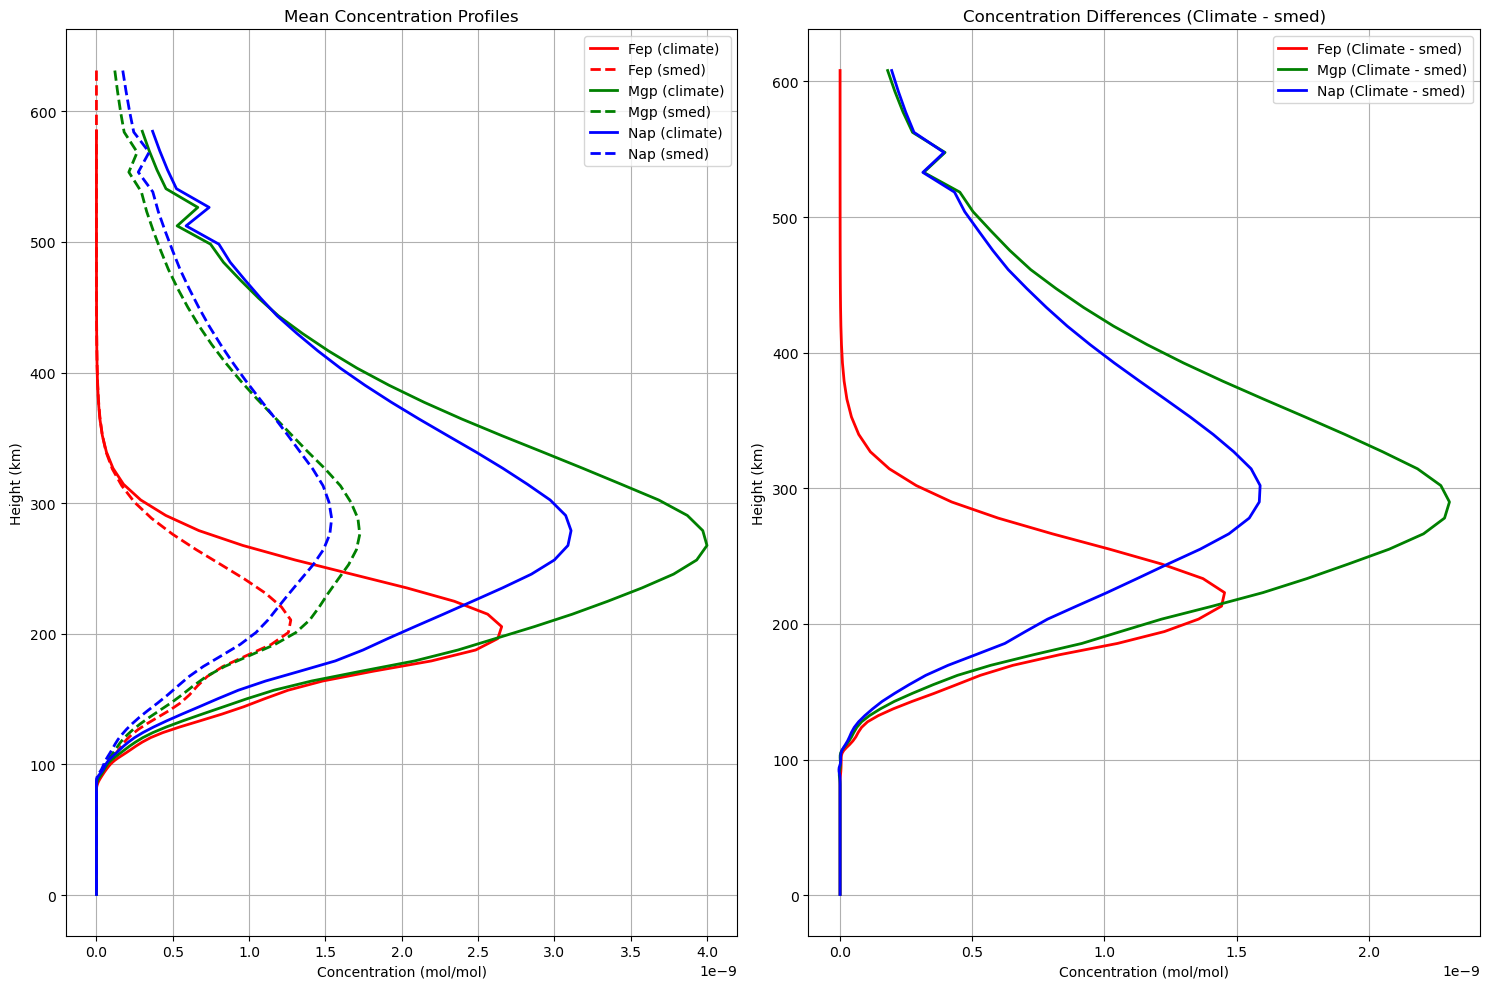

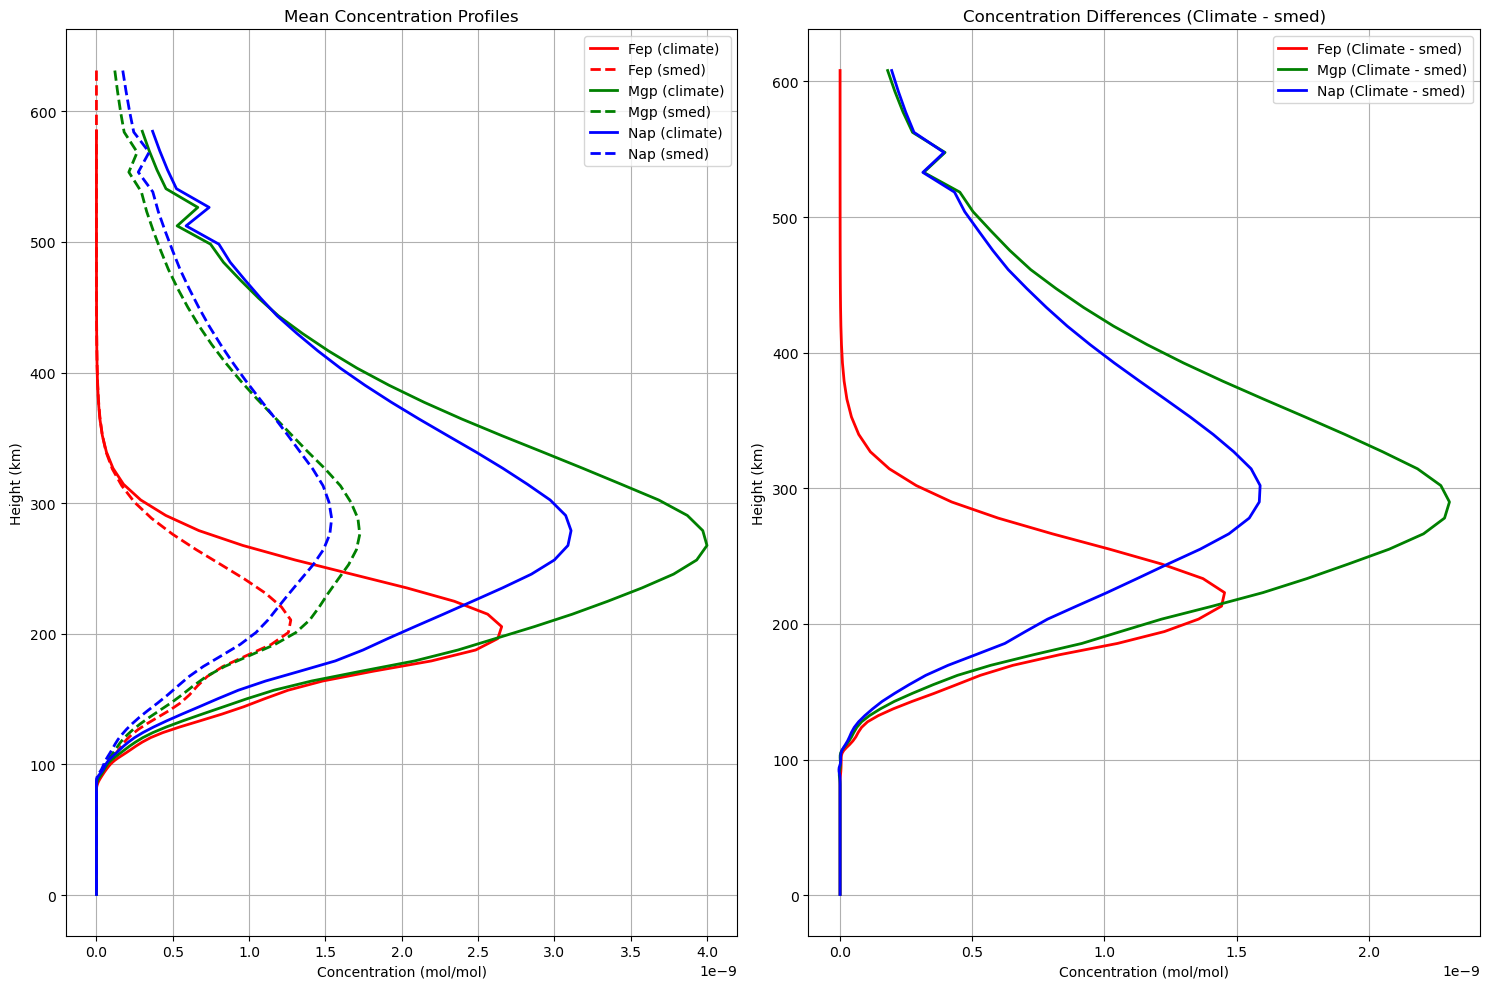

In [19]:
climate_path = "/resstore/b0243/Data/Sporadic_E/FX2100f19f19mg16NaFeMgiontransport_OUTPUT/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
Smed_path = "/resstore/b0243/Data/Sporadic_E/Solar_Med/archive_yr2000/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-{month}-{day}-*.nc"
plot_height_profile_ions(climate_path, Smed_path)

In [10]:
def plot_height_profile(base_path_climate, base_path_smed):
    fig = plt.figure(figsize=(15, 10))
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    data = {
        'climate': {'Fe': [], 'Mg': [], 'Na': [], 'heights': []},
        'smed': {'Fe': [], 'Mg': [], 'Na': [], 'heights': []}
    }
    
    for scenario, base_path in [('climate', base_path_climate), ('smed', base_path_smed)]:
        for month in [f"{i:02d}" for i in range(1, 13)]:
            file_pattern = base_path.format(month=month, day='*')
            files = glob.glob(file_pattern)
            
            ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')
            
            for element in ['Fe', 'Mg', 'Na']:
                element_profile = ds[element].mean(dim=['time', 'lat', 'lon'])
                data[scenario][element].append(element_profile.values)
            
            # Calculate geometric height for each level
            z3_var = ds.variables['Z3']
            h_geopotential = z3_var[0, :, :, :].mean(dim=['lat', 'lon']) 
            
            # Convert geopotential height to geometric height
            R_e = 6371000.0 
            z_geometric = (R_e * h_geopotential) / (R_e - h_geopotential)
            data[scenario]['heights'].append(z_geometric.values / 1000.0) 
            
            ds.close()
    
    for scenario in data:
        for element in ['Fe', 'Mg', 'Na']:
            data[scenario][element] = np.array(data[scenario][element])
        data[scenario]['heights'] = np.array(data[scenario]['heights'])
        data[scenario]['mean_height'] = np.mean(data[scenario]['heights'], axis=0)
    
    colors = {'Fe': 'r', 'Mg': 'g', 'Na': 'b'}
    line_styles = {'climate': '-', 'smed': '--'}
    
    for element, color in colors.items():
        for scenario, linestyle in line_styles.items():
            annual_mean = np.mean(data[scenario][element], axis=0)
            ax1.plot(
                annual_mean, 
                data[scenario]['mean_height'], 
                color=color, 
                linestyle=linestyle, 
                linewidth=2, 
                label=f'{element} ({scenario})'
            )
    
    for element, color in colors.items():
        climate_mean = np.mean(data['climate'][element], axis=0)
        smed_mean = np.mean(data['smed'][element], axis=0)
        
        difference = climate_mean - smed_mean
        
        # Use average of both height profiles for plotting differences
        mean_height = (data['climate']['mean_height'] + data['smed']['mean_height']) / 2
        
        ax2.plot(
            difference, 
            mean_height, 
            color=color, 
            linewidth=2, 
            label=f'{element} (Climate - smed)'
        )
    
    for ax, title in [(ax1, 'Mean Concentration Profiles'), (ax2, 'Concentration Differences (Climate - smed)')]:
        ax.grid(True)
        ax.set_xlabel('Concentration (mol/mol)')
        ax.set_ylabel('Height (km)')
        ax.set_title(title)
        ax.legend()
    
    plt.tight_layout()
    return fig

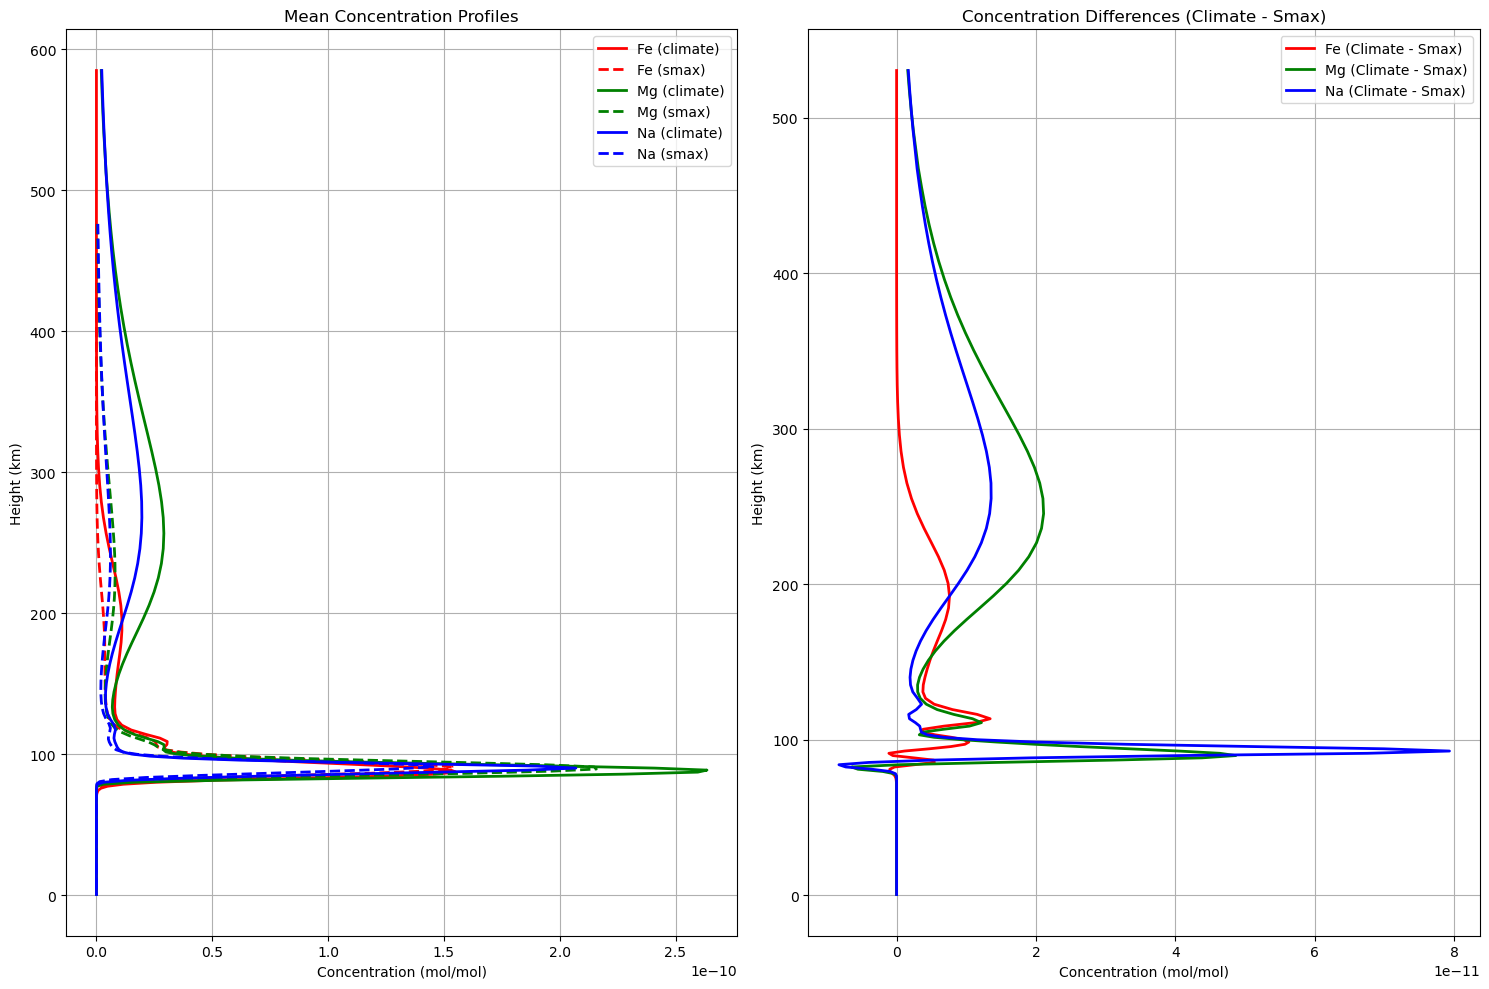

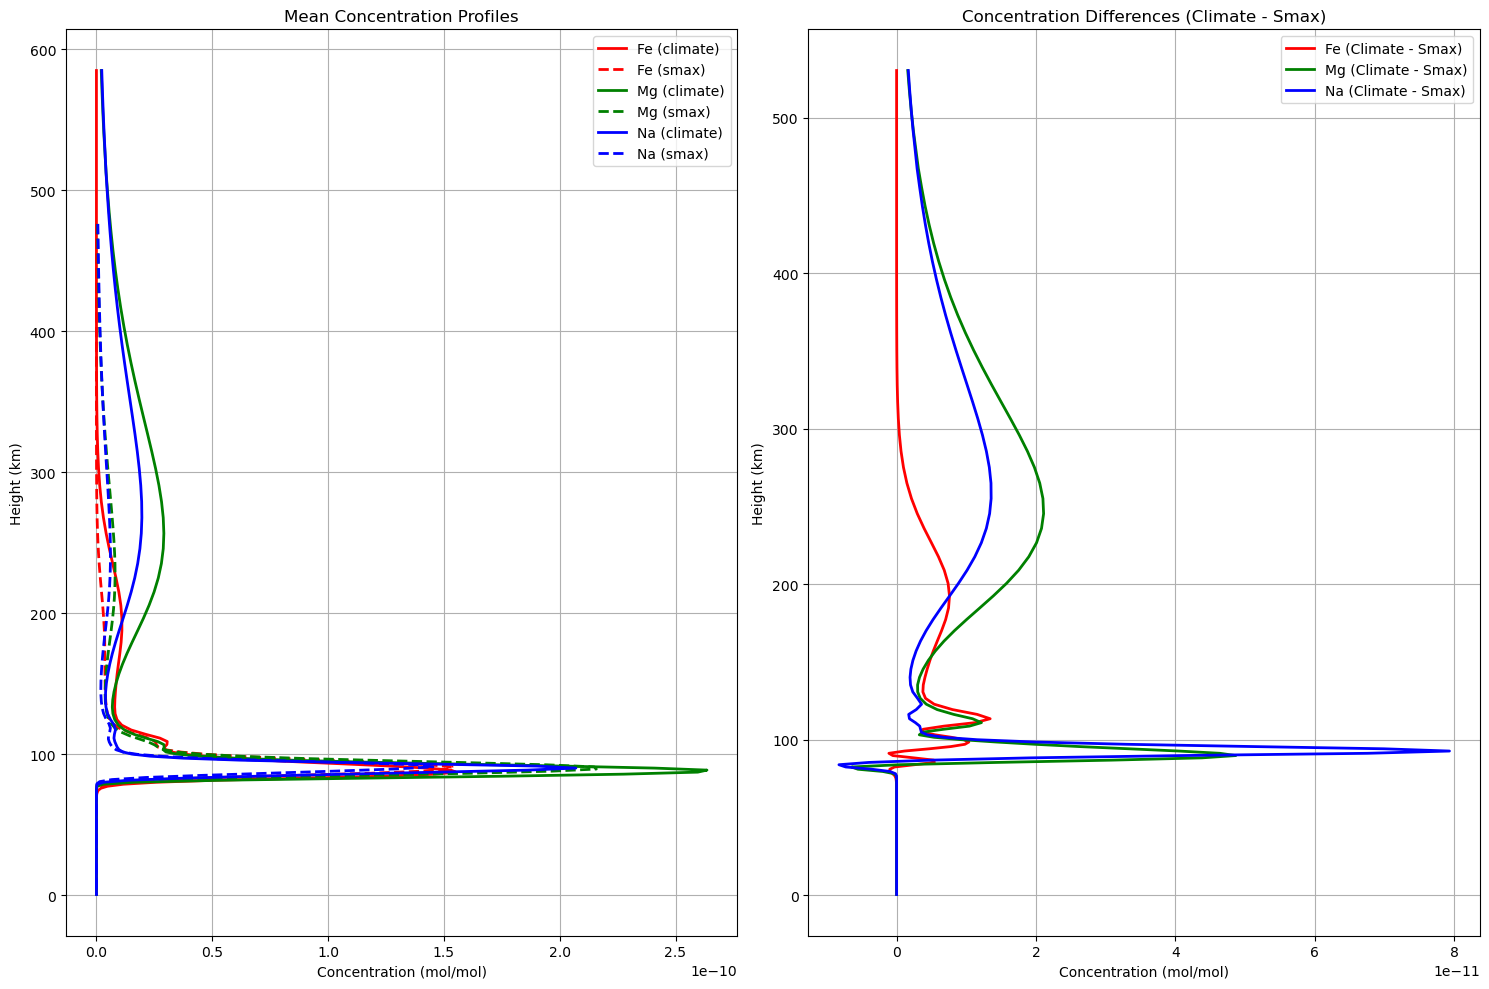

In [6]:
climate_path = "/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
smed_path = "/resstore/b0243/Data/Sporadic_E/Solar_Max/archive_yr2000/atm/hist/smed_3M_FX2000_f19f19mg16.cam.h1.0001-{month}-{day}-*.nc"
plot_height_profile(climate_path, smed_path)

In [20]:
def plot_height_profile_ions(base_path_climate, base_path_smed):
    fig = plt.figure(figsize=(15, 10))
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    data = {
        'climate': {'Fep': [], 'Mgp': [], 'Nap': [], 'heights': []},
        'smed': {'Fep': [], 'Mgp': [], 'Nap': [], 'heights': []}
    }

    target_months = [f"{i:02d}" for i in range(3, 6)]
    
    for scenario, base_path in [('climate', base_path_climate), ('smed', base_path_smed)]:
        for month in target_months:
            file_pattern = base_path.format(month=month, day='*')
            files = glob.glob(file_pattern)
            
            ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')

            lat_mask = (ds.lat >= -55) & (ds.lat <= -45)
            ds_filtered = ds.sel(lat=ds.lat[lat_mask])
            
            for element in ['Fep', 'Mgp', 'Nap']:
                element_profile = ds_filtered[element].mean(dim=['time', 'lat', 'lon'])
                data[scenario][element].append(element_profile.values)

            z3_var = ds_filtered.variables['Z3']
            h_geopotential = z3_var.mean(dim=['time', 'lat', 'lon'])
            data[scenario]['heights'].append(h_geopotential.values / 1000.0)
            
            ds.close()
            
    for scenario in data:
        for element in ['Fep', 'Mgp', 'Nap']:
            data[scenario][element] = np.array(data[scenario][element])
        data[scenario]['heights'] = np.array(data[scenario]['heights'])
        data[scenario]['mean_height'] = np.mean(data[scenario]['heights'], axis=0)
    
    colors = {'Fep': 'r', 'Mgp': 'g', 'Nap': 'b'}
    line_styles = {'climate': '-', 'smed': '--'}
    
    for element, color in colors.items():
        for scenario, linestyle in line_styles.items():
            seasonal_mean = np.mean(data[scenario][element], axis=0)
            ax1.plot(
                seasonal_mean, 
                data[scenario]['mean_height'], 
                color=color, 
                linestyle=linestyle, 
                linewidth=2, 
                label=f'{element} ({scenario})'
            )
    
    for element, color in colors.items():
        climate_mean = np.mean(data['climate'][element], axis=0)
        smed_mean = np.mean(data['smed'][element], axis=0)
        difference = climate_mean - smed_mean
        ax2.plot(
            difference, 
            data['climate']['mean_height'], 
            color=color, 
            linewidth=2, 
            label=f'{element} (Climate - smed)'
        )
    
    for ax, title in [(ax1, 'Mean Concentration Profiles (MAM, -55°N to -45°N)'), 
                       (ax2, 'Concentration Differences (Climate - smed) (MAM, -55°N to -45°N)')]:
        ax.grid(True)
        ax.set_xlabel('Concentration (mol/mol)')
        ax.set_ylabel('Z3 Height (km)')  
        ax.set_title(title)
        ax.set_ylim(80, 150)
        # ax.set_xlim()
        ax.legend()
    
    plt.tight_layout()
    return fig

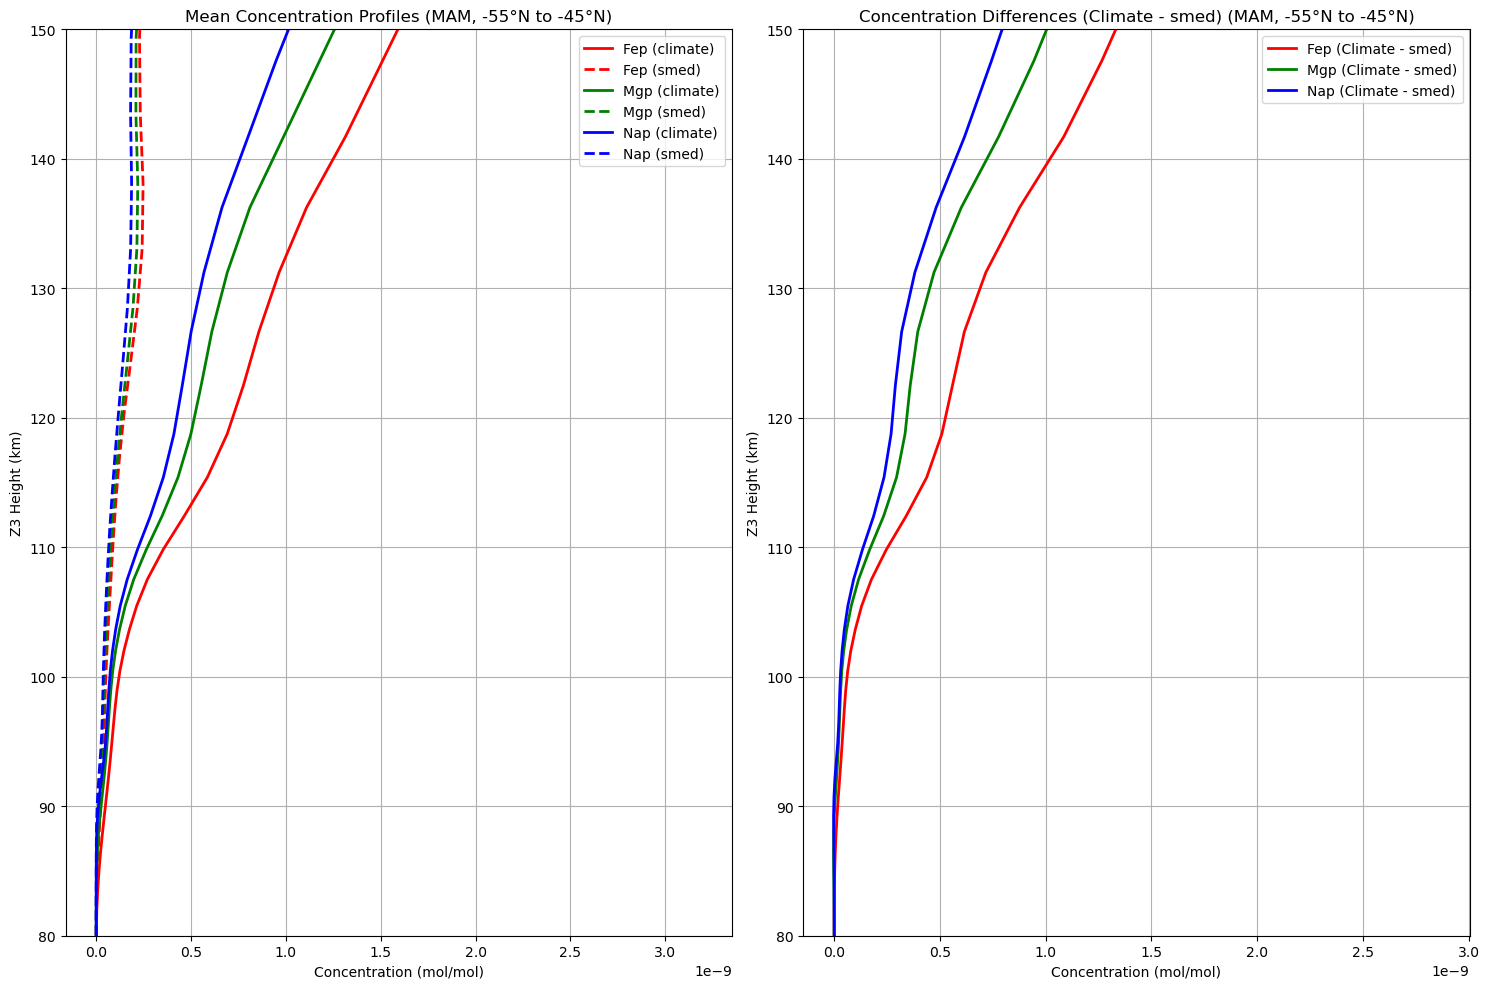

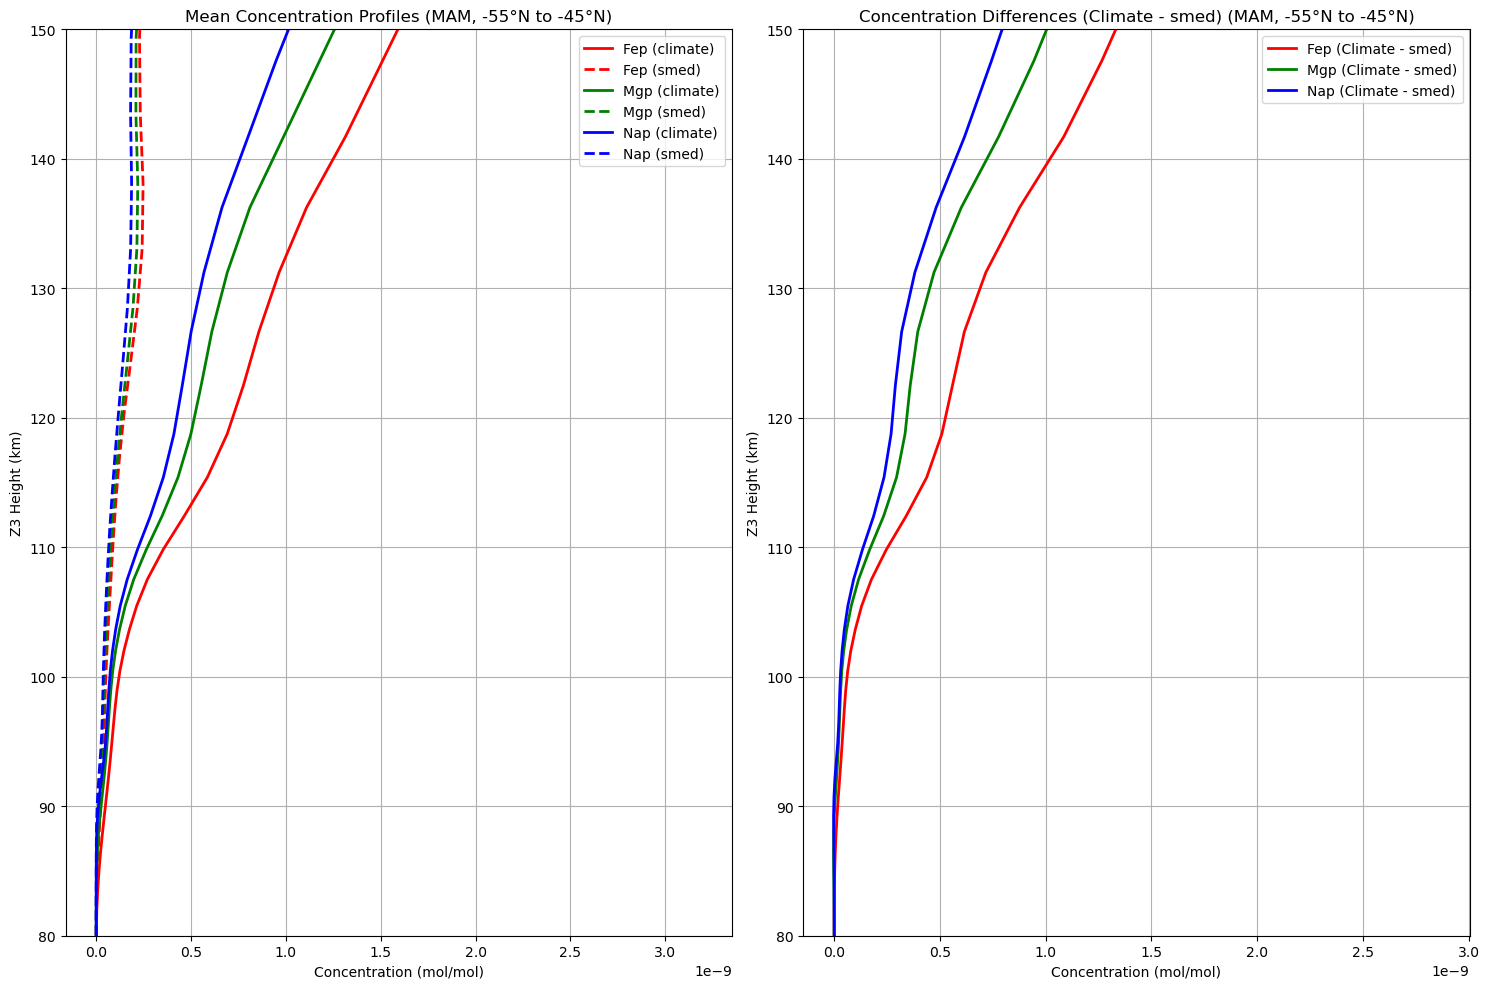

In [21]:
climate_path = "/resstore/b0243/Data/Sporadic_E/FX2100f19f19mg16NaFeMgiontransport_OUTPUT/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
Smed_path = "/resstore/b0243/Data/Sporadic_E/Solar_Med/archive_yr2000/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-{month}-{day}-*.nc"
plot_height_profile_ions(climate_path, Smed_path)

In [22]:
def plot_height_profile_ions(base_path_climate, base_path_smed, output_dir='./output_data'):
    fig = plt.figure(figsize=(15, 10))
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    data = {
        'climate': {'Fep': [], 'Mgp': [], 'Nap': [], 'heights': []},
        'smed': {'Fep': [], 'Mgp': [], 'Nap': [], 'heights': []}
    }
    
    target_months = ['12', '01', '02']
    
    for scenario, base_path in [('climate', base_path_climate), ('smed', base_path_smed)]:
        for month in target_months:
            file_pattern = base_path.format(month=month, day='*')
            files = glob.glob(file_pattern)
            
            ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')

            lat_mask = (ds.lat >= 15) & (ds.lat <= 25)
            ds_filtered = ds.sel(lat=ds.lat[lat_mask])
            
            for element in ['Fep', 'Mgp', 'Nap']:
                element_profile = ds_filtered[element].mean(dim=['time', 'lat', 'lon'])
                data[scenario][element].append(element_profile.values)

            z3_var = ds_filtered.variables['Z3']
            h_geopotential = z3_var[0, :, :, :].mean(dim=['lat', 'lon']) 

            data[scenario]['heights'].append(h_geopotential.values / 1000.0)
            
            ds.close()
            
    for scenario in data:
        for element in ['Fep', 'Mgp', 'Nap']:
            data[scenario][element] = np.array(data[scenario][element])
        data[scenario]['heights'] = np.array(data[scenario]['heights'])
        data[scenario]['mean_height'] = np.mean(data[scenario]['heights'], axis=0)

    os.makedirs(output_dir, exist_ok=True)

    for element in ['Fep', 'Mgp', 'Nap']:
        for scenario in ['climate', 'smed']:
            seasonal_mean = np.mean(data[scenario][element], axis=0)
            heights = data[scenario]['mean_height']
            
            filename = f"{output_dir}/{element}_{scenario}_mean_concentration.txt"
            with open(filename, 'w') as f:
                f.write(f"# {element} mean concentration profile for {scenario} scenario (DJF, 0° to 40°N)\n")
                f.write("# Height(km)\tConcentration(mol/mol)\n")
                for i in range(len(heights)):
                    f.write(f"{heights[i]:.6f}\t{seasonal_mean[i]:.6e}\n")

        climate_mean = np.mean(data['climate'][element], axis=0)
        smed_mean = np.mean(data['smed'][element], axis=0)
        difference = climate_mean - smed_mean
        heights = data['climate']['mean_height']
        
        filename = f"{output_dir}/{element}_difference_concentration.txt"
        with open(filename, 'w') as f:
            f.write(f"# {element} concentration difference (Climate - smed) (DJF, 0° to 40°N)\n")
            f.write("# Height(km)\tDifference(mol/mol)\n")
            for i in range(len(heights)):
                f.write(f"{heights[i]:.6f}\t{difference[i]:.6e}\n")
    
    colors = {'Fep': 'r', 'Mgp': 'g', 'Nap': 'b'}
    line_styles = {'climate': '-', 'smed': '--'}
    
    for element, color in colors.items():
        for scenario, linestyle in line_styles.items():
            seasonal_mean = np.mean(data[scenario][element], axis=0)
            ax1.plot(
                seasonal_mean, 
                data[scenario]['mean_height'], 
                color=color, 
                linestyle=linestyle, 
                linewidth=2, 
                label=f'{element} ({scenario})'
            )
    
    for element, color in colors.items():
        climate_mean = np.mean(data['climate'][element], axis=0)
        smed_mean = np.mean(data['smed'][element], axis=0)
        difference = climate_mean - smed_mean
        ax2.plot(
            difference, 
            data['climate']['mean_height'], 
            color=color, 
            linewidth=2, 
            label=f'{element} (Climate - smed)'
        )
        
    for ax, title in [(ax1, 'Mean Concentration Profiles (DJF, 15° to 25°N)'), 
                       (ax2, 'Concentration Differences (Climate - smed) (DJF, 15° to 25°N)')]:
        ax.grid(True)
        ax.set_xlabel('Concentration (mol/mol)')
        ax.set_ylabel('Z3 Height (km)')
        ax.set_title(title)
        ax.set_ylim(80,150)
        ax.legend()

    plt.tight_layout()
    return fig

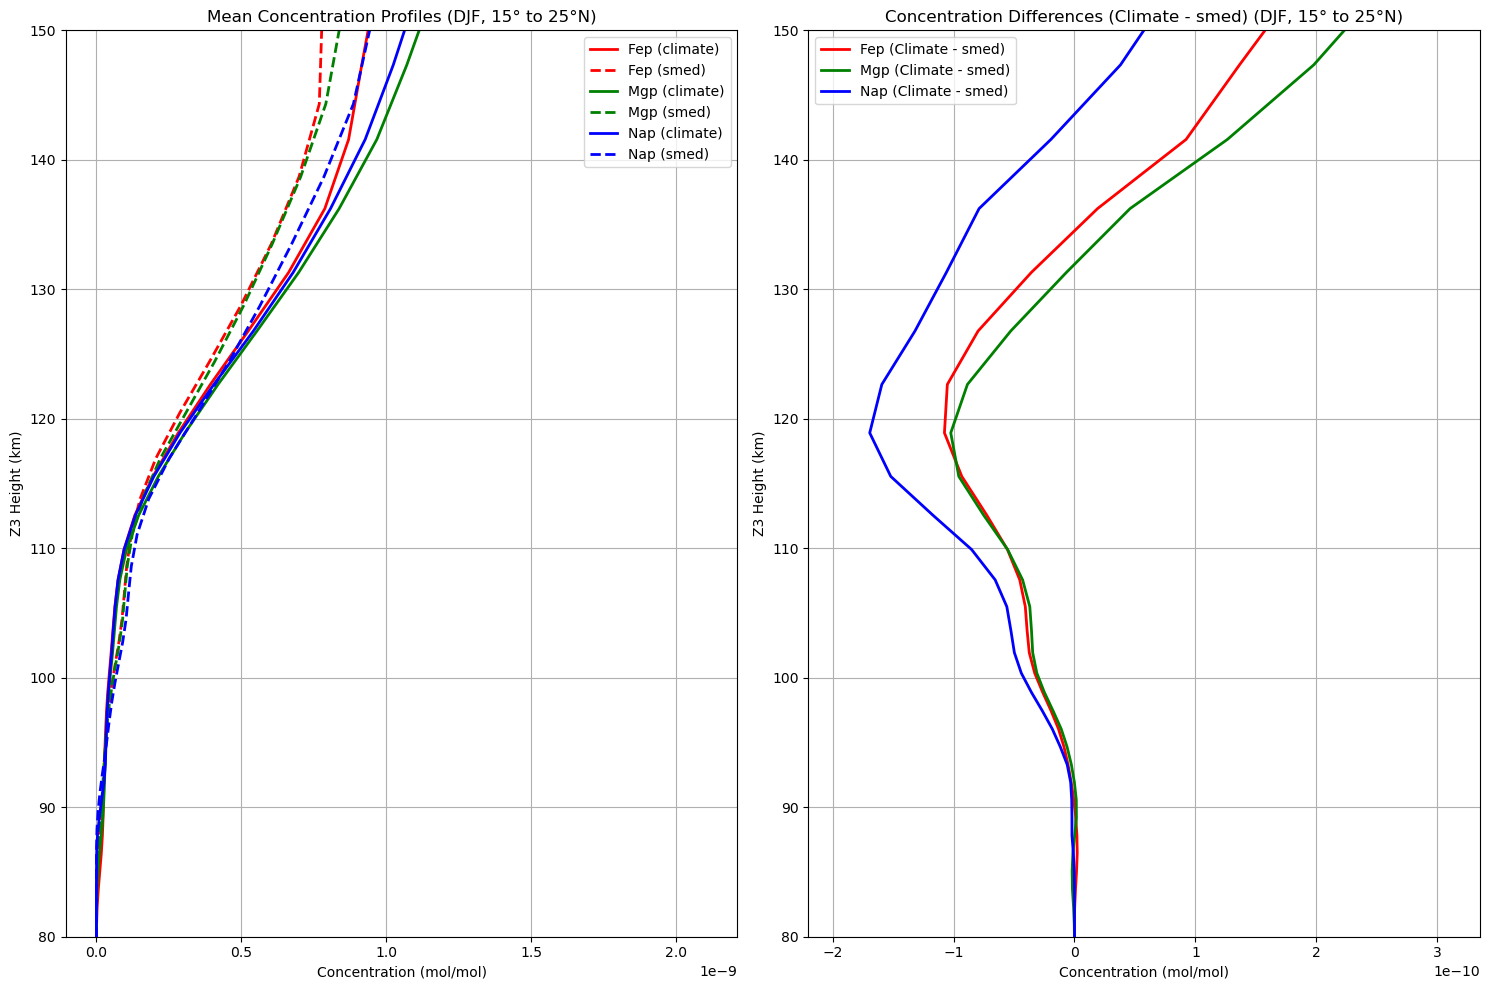

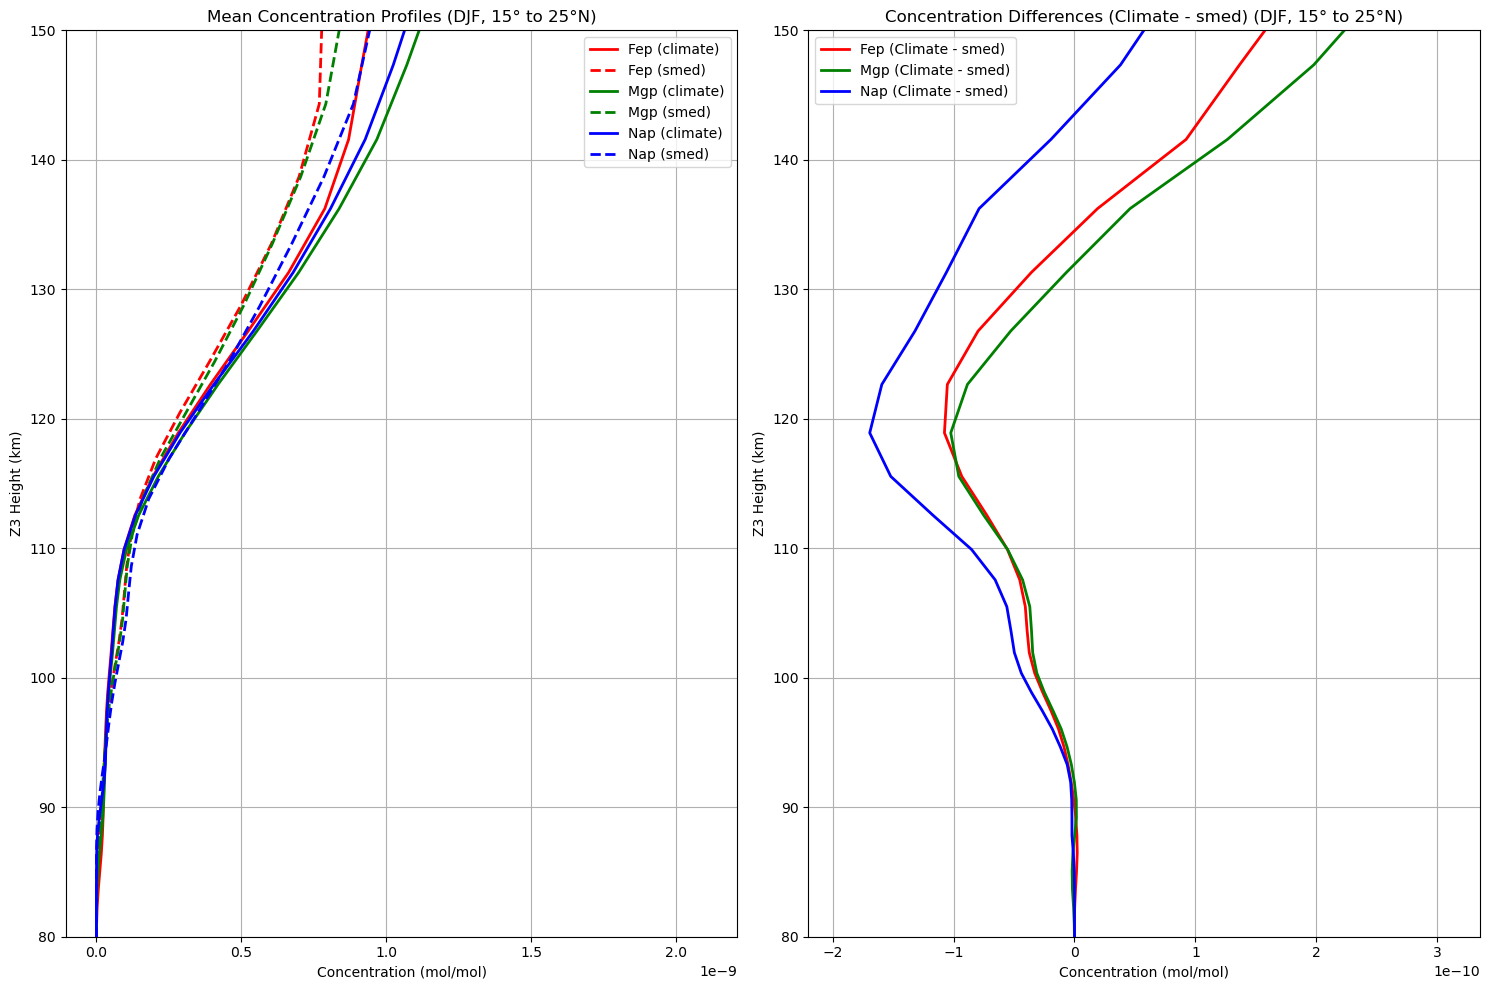

In [24]:
climate_path = "/resstore/b0243/Data/Sporadic_E/FX2100f19f19mg16NaFeMgiontransport_OUTPUT/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
Smed_path = "/resstore/b0243/Data/Sporadic_E/Solar_Med/archive_yr2000/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-{month}-{day}-*.nc"
plot_height_profile_ions(climate_path, Smed_path)

In [25]:
def plot_height_profile_ions(base_path_climate, base_path_smed, output_dir='./output_data'):
    fig = plt.figure(figsize=(15, 10))
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    data = {
        'climate': {'e': [], 'heights': []},
        'smed': {'e': [],  'heights': []}
    }
    
    target_months = ['12', '01', '02']
    
    for scenario, base_path in [('climate', base_path_climate), ('smed', base_path_smed)]:
        for month in target_months:
            file_pattern = base_path.format(month=month, day='*')
            files = glob.glob(file_pattern)
            
            ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')
            
            # Filter latitude between 0 and 40 (Northern Hemisphere)
            lat_mask = (ds.lat >= 15) & (ds.lat <= 25)
            ds_filtered = ds.sel(lat=ds.lat[lat_mask])
            
            for element in ['e']:
                element_profile = ds_filtered[element].mean(dim=['time', 'lat', 'lon'])
                data[scenario][element].append(element_profile.values)
            
            # Use Z3 directly without conversion to geometric height
            z3_var = ds_filtered.variables['Z3']
            h_geopotential = z3_var[0, :, :, :].mean(dim=['lat', 'lon']) 
            
            # Store Z3 values directly in km (dividing by 1000 to convert from m to km)
            data[scenario]['heights'].append(h_geopotential.values / 1000.0)
            
            ds.close()
            
    for scenario in data:
        for element in ['e']:
            data[scenario][element] = np.array(data[scenario][element])
        data[scenario]['heights'] = np.array(data[scenario]['heights'])
        data[scenario]['mean_height'] = np.mean(data[scenario]['heights'], axis=0)
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save mean concentrations to text files for each ion
    for element in ['e']:
        for scenario in ['climate', 'smed']:
            seasonal_mean = np.mean(data[scenario][element], axis=0)
            heights = data[scenario]['mean_height']
            
            # Create a file for each ion and scenario
            filename = f"{output_dir}/{element}_{scenario}_mean_concentration.txt"
            with open(filename, 'w') as f:
                f.write(f"# {element} mean concentration profile for {scenario} scenario (DJF, 0° to 40°N)\n")
                f.write("# Height(km)\tConcentration(mol/mol)\n")
                for i in range(len(heights)):
                    f.write(f"{heights[i]:.6f}\t{seasonal_mean[i]:.6e}\n")
        
        # Also save the difference (climate - smed) for each ion
        climate_mean = np.mean(data['climate'][element], axis=0)
        smed_mean = np.mean(data['smed'][element], axis=0)
        difference = climate_mean - smed_mean
        heights = data['climate']['mean_height']
        
        # Create a file for the difference
        filename = f"{output_dir}/{element}_difference_concentration.txt"
        with open(filename, 'w') as f:
            f.write(f"# {element} concentration difference (Climate - smed) (DJF, 0° to 40°N)\n")
            f.write("# Height(km)\tDifference(mol/mol)\n")
            for i in range(len(heights)):
                f.write(f"{heights[i]:.6f}\t{difference[i]:.6e}\n")
    
    colors = {'e': 'r'}
    line_styles = {'climate': '-', 'smed': '--'}
    
    for element, color in colors.items():
        for scenario, linestyle in line_styles.items():
            seasonal_mean = np.mean(data[scenario][element], axis=0)
            ax1.plot(
                seasonal_mean, 
                data[scenario]['mean_height'], 
                color=color, 
                linestyle=linestyle, 
                linewidth=2, 
                label=f'{element} ({scenario})'
            )
    
    for element, color in colors.items():
        climate_mean = np.mean(data['climate'][element], axis=0)
        smed_mean = np.mean(data['smed'][element], axis=0)
        difference = climate_mean - smed_mean
        ax2.plot(
            difference, 
            data['climate']['mean_height'], 
            color=color, 
            linewidth=2, 
            label=f'{element} (Climate - smed)'
        )
    
    for ax, title in [(ax1, 'Mean Concentration Profiles (DJF, 15° to 25°N)'), 
                       (ax2, 'Concentration Differences (Climate - smed) (DJF, 15° to 25°N)')]:
        ax.grid(True)
        ax.set_xlabel('Concentration (mol/mol)')
        ax.set_ylabel('Z3 Height (km)')
        ax.set_title(title)
        ax.legend()
    
    plt.tight_layout()
    return fig

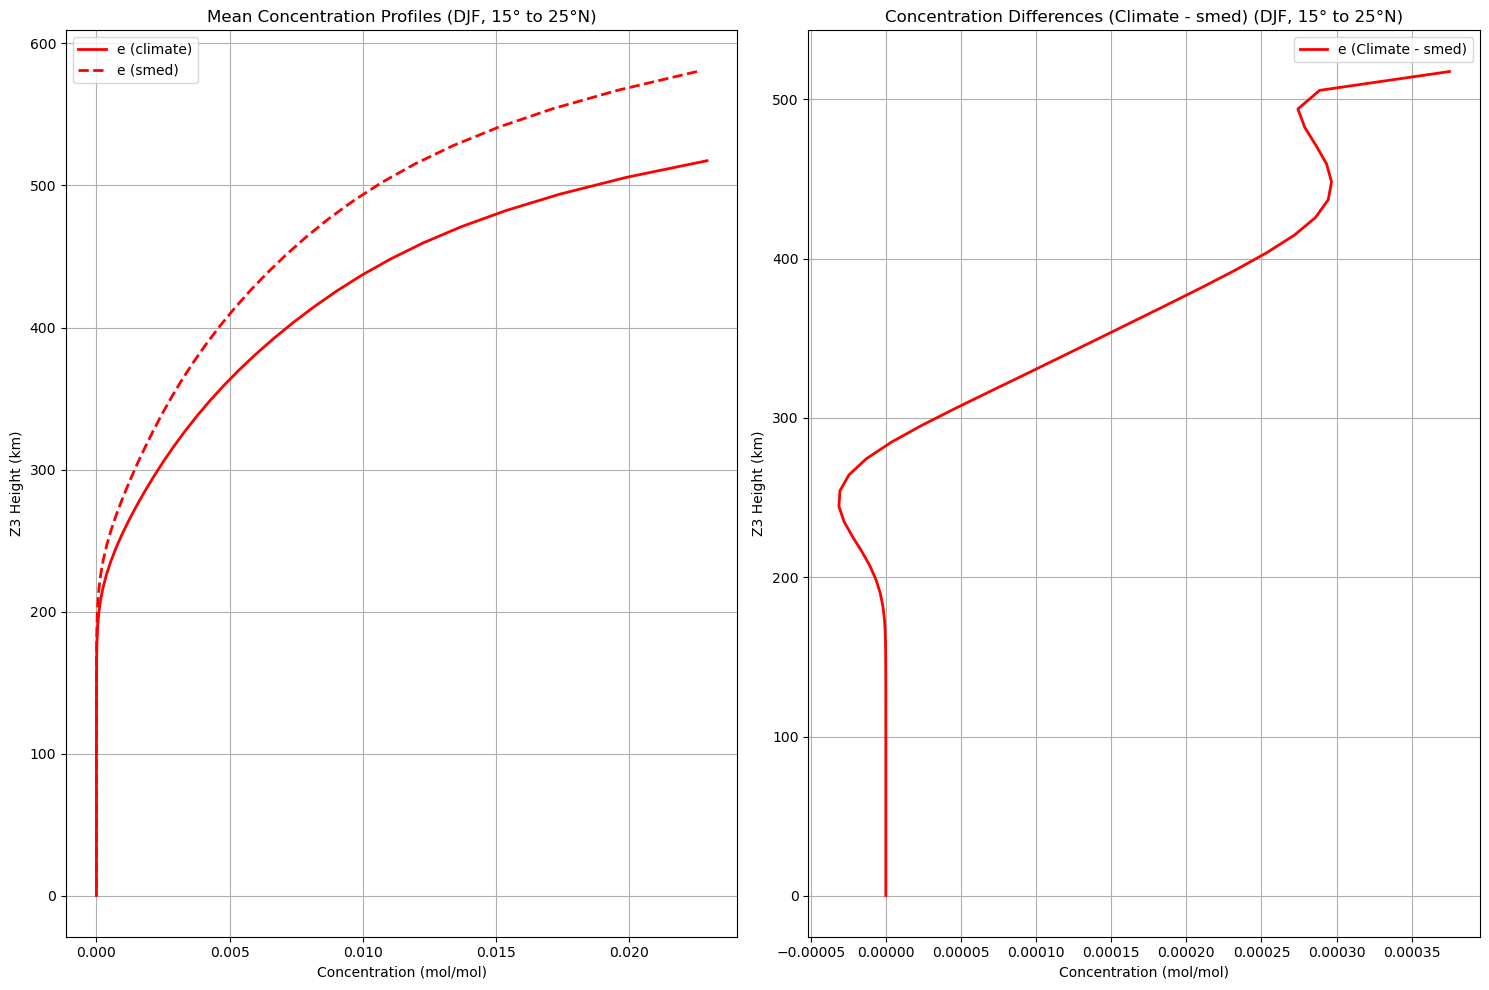

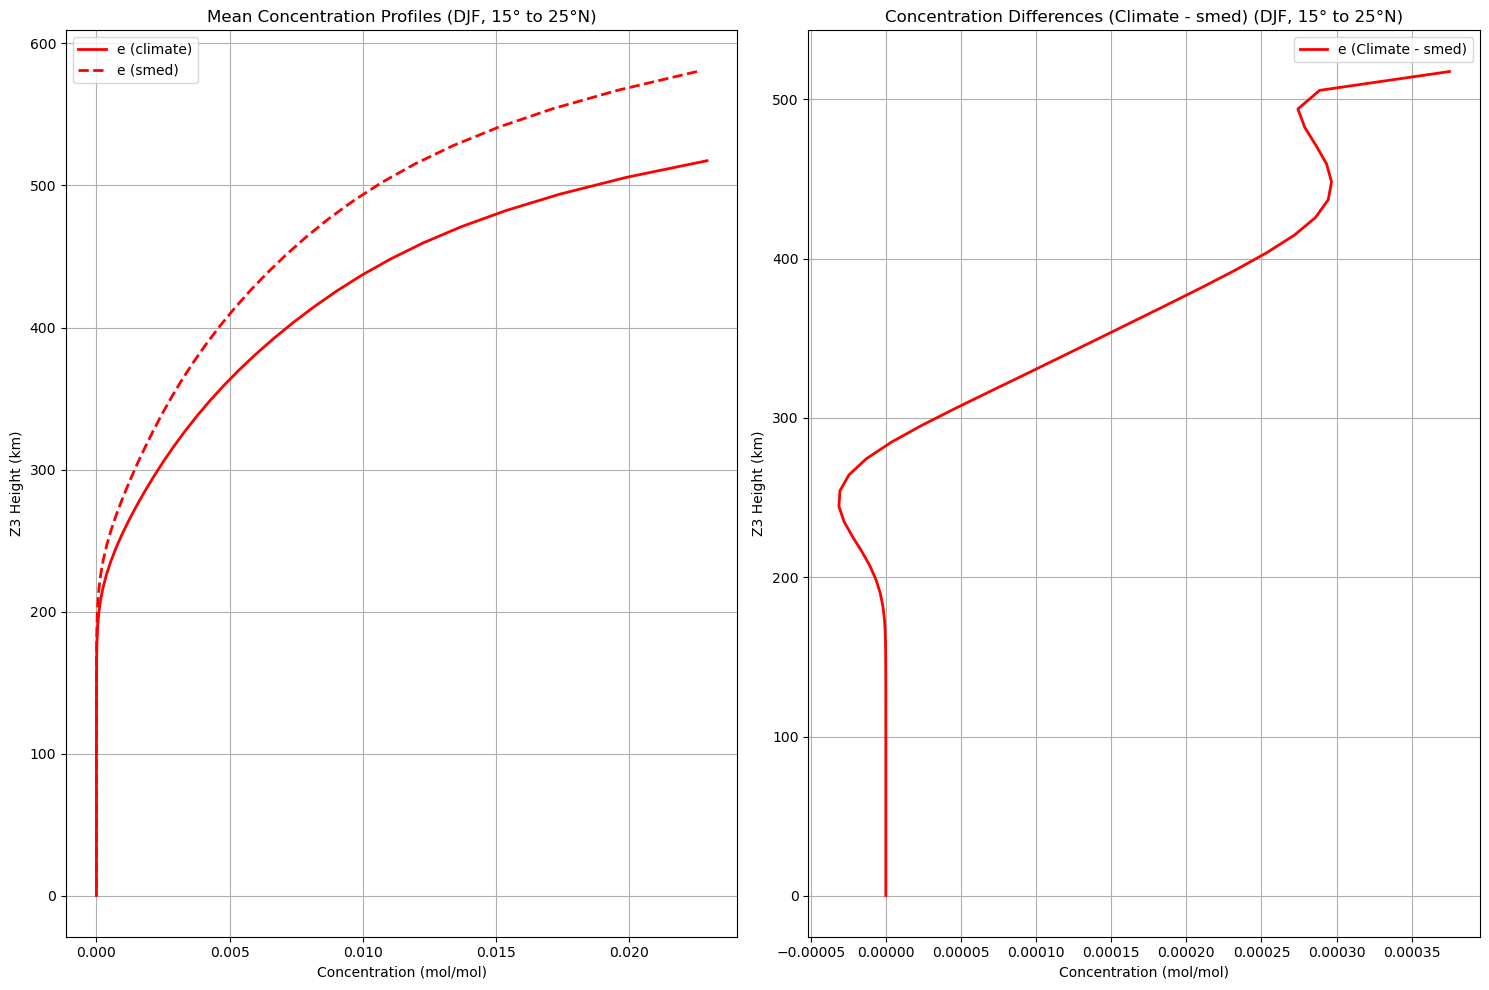

In [26]:
climate_path = "/resstore/b0243/Data/Sporadic_E/FX2100f19f19mg16NaFeMgiontransport_OUTPUT/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
Smed_path = "/resstore/b0243/Data/Sporadic_E/Solar_Med/archive_yr2000/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-{month}-{day}-*.nc"
plot_height_profile_ions(climate_path, Smed_path)

In [27]:
def plot_height_profile_ions(base_path_climate, base_path_smed):
    fig = plt.figure(figsize=(15, 10))
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    data = {
        'climate': {'e': [], 'heights': []},
        'smed': {'e': [],  'heights': []}
    }
    
    # Only consider March, April, and May
    target_months = [f"{i:02d}" for i in range(3, 6)]
    
    for scenario, base_path in [('climate', base_path_climate), ('smed', base_path_smed)]:
        for month in target_months:
            file_pattern = base_path.format(month=month, day='*')
            files = glob.glob(file_pattern)
            
            ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')
            
            # Filter latitude between -60 and -20
            lat_mask = (ds.lat >= -60) & (ds.lat <= -20)
            ds_filtered = ds.sel(lat=ds.lat[lat_mask])
            
            for element in ['e']:
                element_profile = ds_filtered[element].mean(dim=['time', 'lat', 'lon'])
                data[scenario][element].append(element_profile.values)

            z3_var = ds_filtered.variables['Z3']
            h_geopotential = z3_var.mean(dim=['time', 'lat', 'lon'])
            data[scenario]['heights'].append(h_geopotential.values / 1000.0)
            
            ds.close()
            
    for scenario in data:
        for element in ['e']:
            data[scenario][element] = np.array(data[scenario][element])
        data[scenario]['heights'] = np.array(data[scenario]['heights'])
        data[scenario]['mean_height'] = np.mean(data[scenario]['heights'], axis=0)
    
    colors = {'e': 'r'}
    line_styles = {'climate': '-', 'smed': '--'}
    
    for element, color in colors.items():
        for scenario, linestyle in line_styles.items():
            seasonal_mean = np.mean(data[scenario][element], axis=0)
            ax1.plot(
                seasonal_mean, 
                data[scenario]['mean_height'], 
                color=color, 
                linestyle=linestyle, 
                linewidth=2, 
                label=f'{element} ({scenario})'
            )
    
    for element, color in colors.items():
        climate_mean = np.mean(data['climate'][element], axis=0)
        smed_mean = np.mean(data['smed'][element], axis=0)
        difference = climate_mean - smed_mean
        ax2.plot(
            difference, 
            data['climate']['mean_height'], 
            color=color, 
            linewidth=2, 
            label=f'{element} (Climate - smed)'
        )
    
    for ax, title in [(ax1, 'Mean Concentration Profiles (MAM, -60° to -20°)'), 
                       (ax2, 'Concentration Differences (Climate - smed) (MAM, -60° to -20°)')]:
        ax.grid(True)
        ax.set_xlabel('Concentration (mol/mol)')
        ax.set_ylabel('Z3 Height (km)')  # Updated label to reflect Z3 usage
        ax.set_title(title)
        ax.legend()
    
    plt.tight_layout()
    return fig

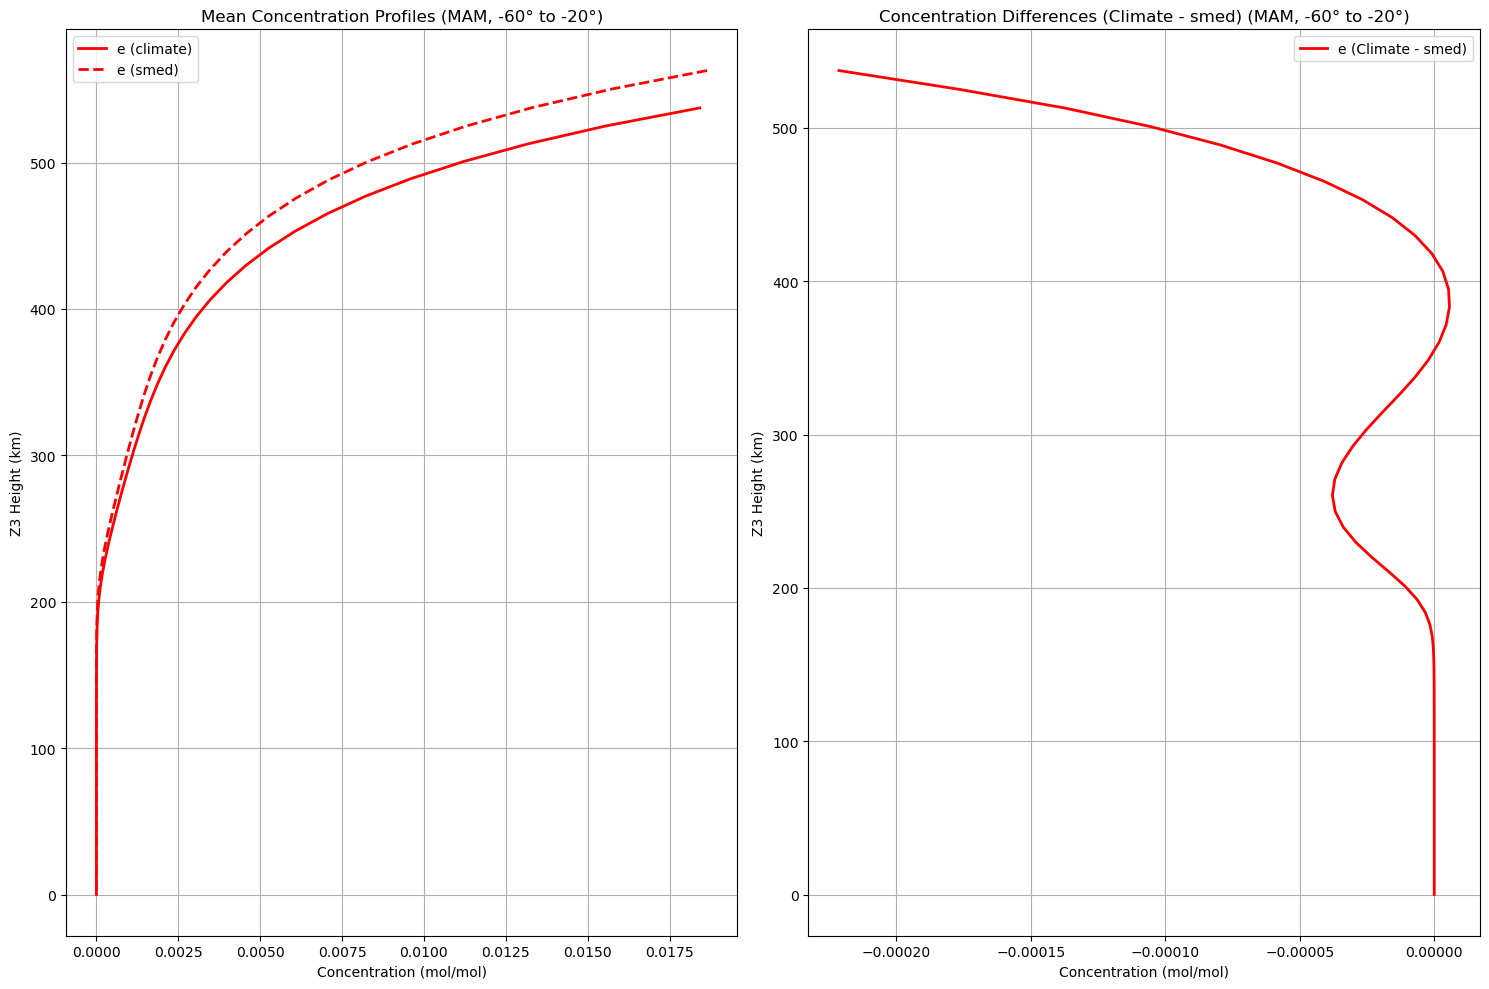

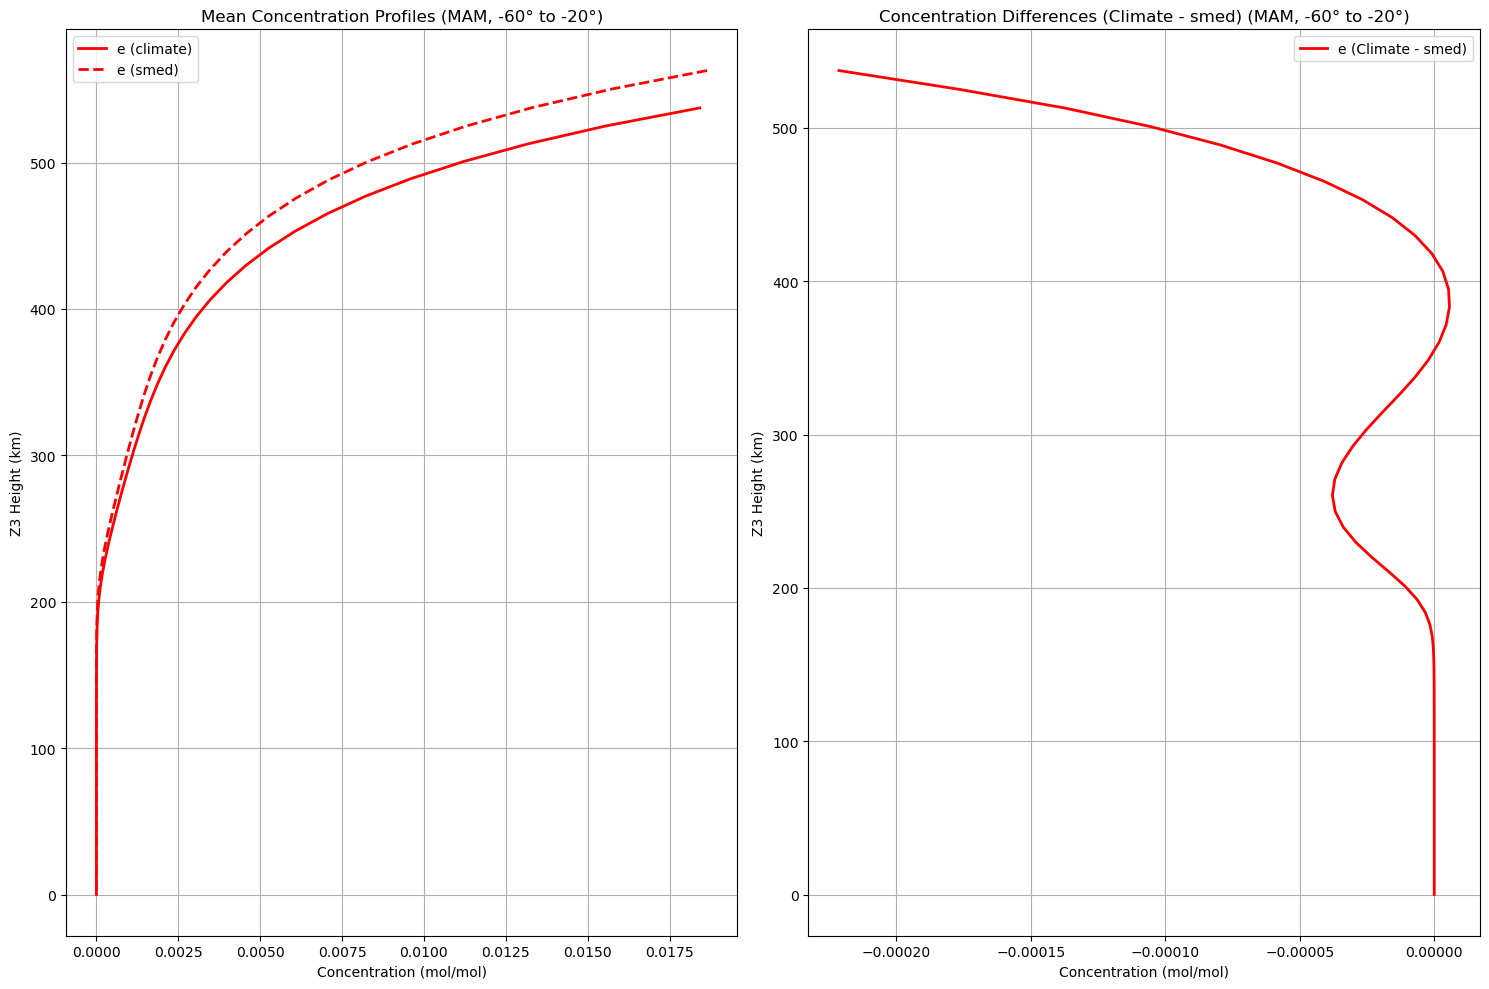

In [28]:
climate_path = "/resstore/b0243/Data/Sporadic_E/FX2100f19f19mg16NaFeMgiontransport_OUTPUT/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
Smed_path = "/resstore/b0243/Data/Sporadic_E/Solar_Med/archive_yr2000/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-{month}-{day}-*.nc"
plot_height_profile_ions(climate_path, Smed_path)

In [29]:
def plot_height_profile_ions(base_path_climate, base_path_smed, output_dir='./output_data'):
    fig = plt.figure(figsize=(15, 10))
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    data = {
        'climate': {'O2p': [], 'heights': []},
        'smed': {'O2p': [], 'heights': []}
    }
    
    target_months = ['12', '01', '02']
    
    for scenario, base_path in [('climate', base_path_climate), ('smed', base_path_smed)]:
        for month in target_months:
            file_pattern = base_path.format(month=month, day='*')
            files = glob.glob(file_pattern)
            
            ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')

            lat_mask = (ds.lat >= 15) & (ds.lat <= 25)
            ds_filtered = ds.sel(lat=ds.lat[lat_mask])
            
            for element in ['O2p']:
                element_profile = ds_filtered[element].mean(dim=['time', 'lat', 'lon'])
                data[scenario][element].append(element_profile.values)

            z3_var = ds_filtered.variables['Z3']
            h_geopotential = z3_var[0, :, :, :].mean(dim=['lat', 'lon']) 

            data[scenario]['heights'].append(h_geopotential.values / 1000.0)
            
            ds.close()
            
    for scenario in data:
        for element in ['O2p']:
            data[scenario][element] = np.array(data[scenario][element])
        data[scenario]['heights'] = np.array(data[scenario]['heights'])
        data[scenario]['mean_height'] = np.mean(data[scenario]['heights'], axis=0)

    os.makedirs(output_dir, exist_ok=True)

    for element in ['O2p']:
        for scenario in ['climate', 'smed']:
            seasonal_mean = np.mean(data[scenario][element], axis=0)
            heights = data[scenario]['mean_height']
            
            filename = f"{output_dir}/{element}_{scenario}_mean_concentration.txt"
            with open(filename, 'w') as f:
                f.write(f"# {element} mean concentration profile for {scenario} scenario (DJF, 0° to 40°N)\n")
                f.write("# Height(km)\tConcentration(mol/mol)\n")
                for i in range(len(heights)):
                    f.write(f"{heights[i]:.6f}\t{seasonal_mean[i]:.6e}\n")

        climate_mean = np.mean(data['climate'][element], axis=0)
        smed_mean = np.mean(data['smed'][element], axis=0)
        difference = climate_mean - smed_mean
        heights = data['climate']['mean_height']
        
        filename = f"{output_dir}/{element}_difference_concentration.txt"
        with open(filename, 'w') as f:
            f.write(f"# {element} concentration difference (Climate - smed) (DJF, 0° to 40°N)\n")
            f.write("# Height(km)\tDifference(mol/mol)\n")
            for i in range(len(heights)):
                f.write(f"{heights[i]:.6f}\t{difference[i]:.6e}\n")
    
    colors = {'O2p': 'r'}
    line_styles = {'climate': '-', 'smed': '--'}
    
    for element, color in colors.items():
        for scenario, linestyle in line_styles.items():
            seasonal_mean = np.mean(data[scenario][element], axis=0)
            ax1.plot(
                seasonal_mean, 
                data[scenario]['mean_height'], 
                color=color, 
                linestyle=linestyle, 
                linewidth=2, 
                label=f'{element} ({scenario})'
            )
    
    for element, color in colors.items():
        climate_mean = np.mean(data['climate'][element], axis=0)
        smed_mean = np.mean(data['smed'][element], axis=0)
        difference = climate_mean - smed_mean
        ax2.plot(
            difference, 
            data['climate']['mean_height'], 
            color=color, 
            linewidth=2, 
            label=f'{element} (Climate - smed)'
        )
        
    for ax, title in [(ax1, 'Mean Concentration Profiles (DJF, 15° to 25°N)'), 
                       (ax2, 'Concentration Differences (Climate - smed) (DJF, 15° to 25°N)')]:
        ax.grid(True)
        ax.set_xlabel('Concentration (mol/mol)')
        ax.set_ylabel('Z3 Height (km)')
        ax.set_title(title)
        ax.set_ylim(80,150)
        ax.legend()

    plt.tight_layout()
    return fig

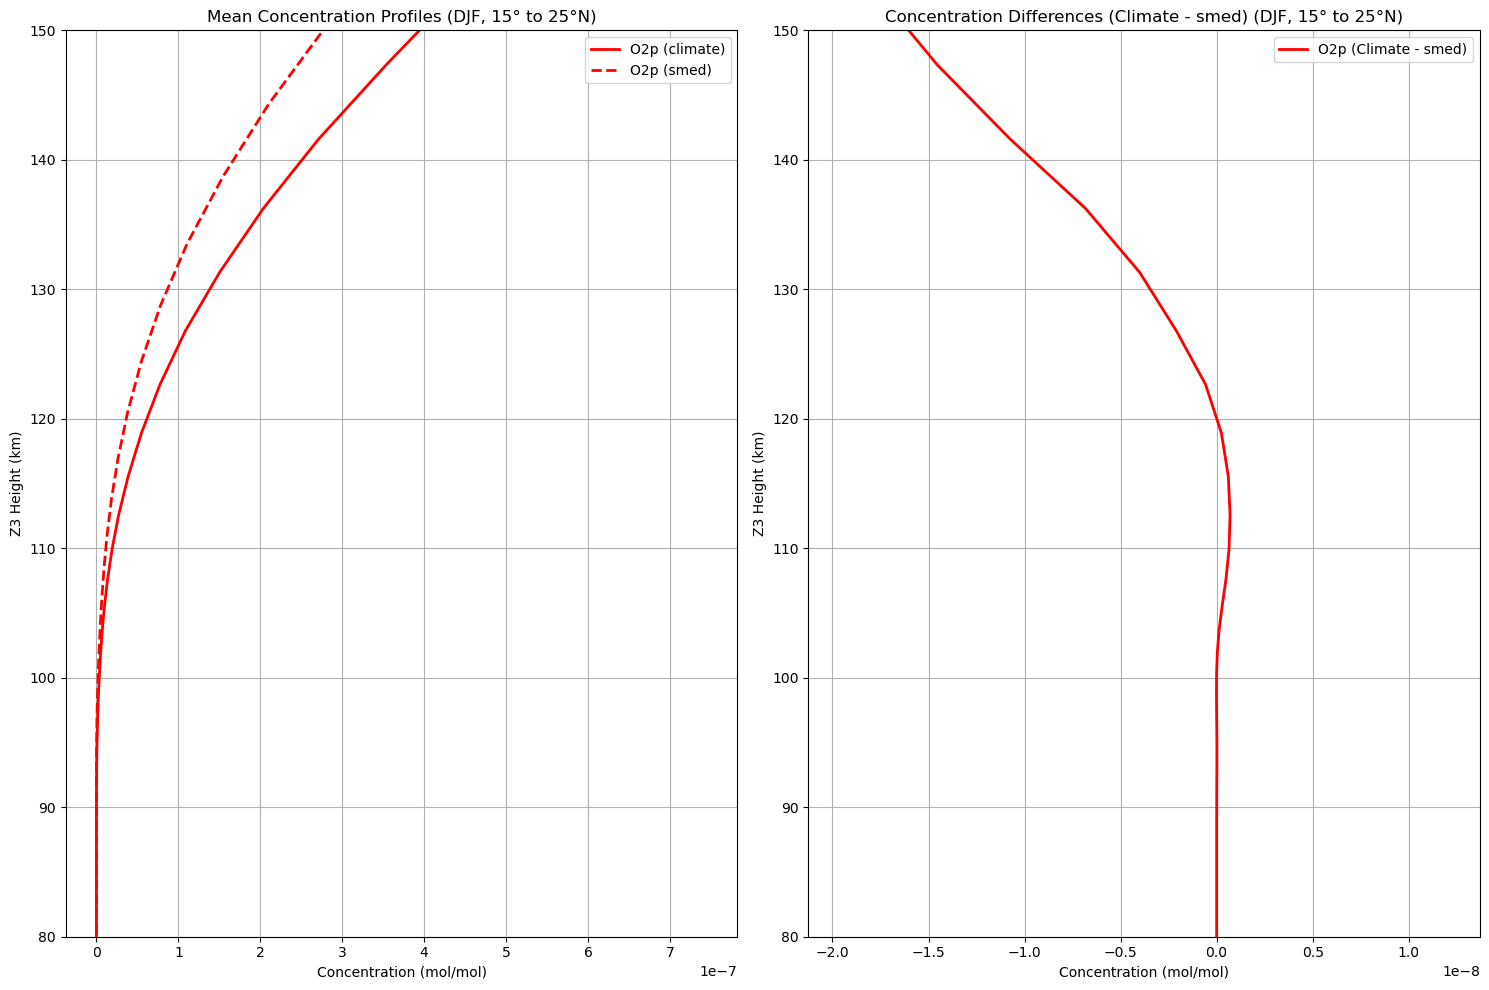

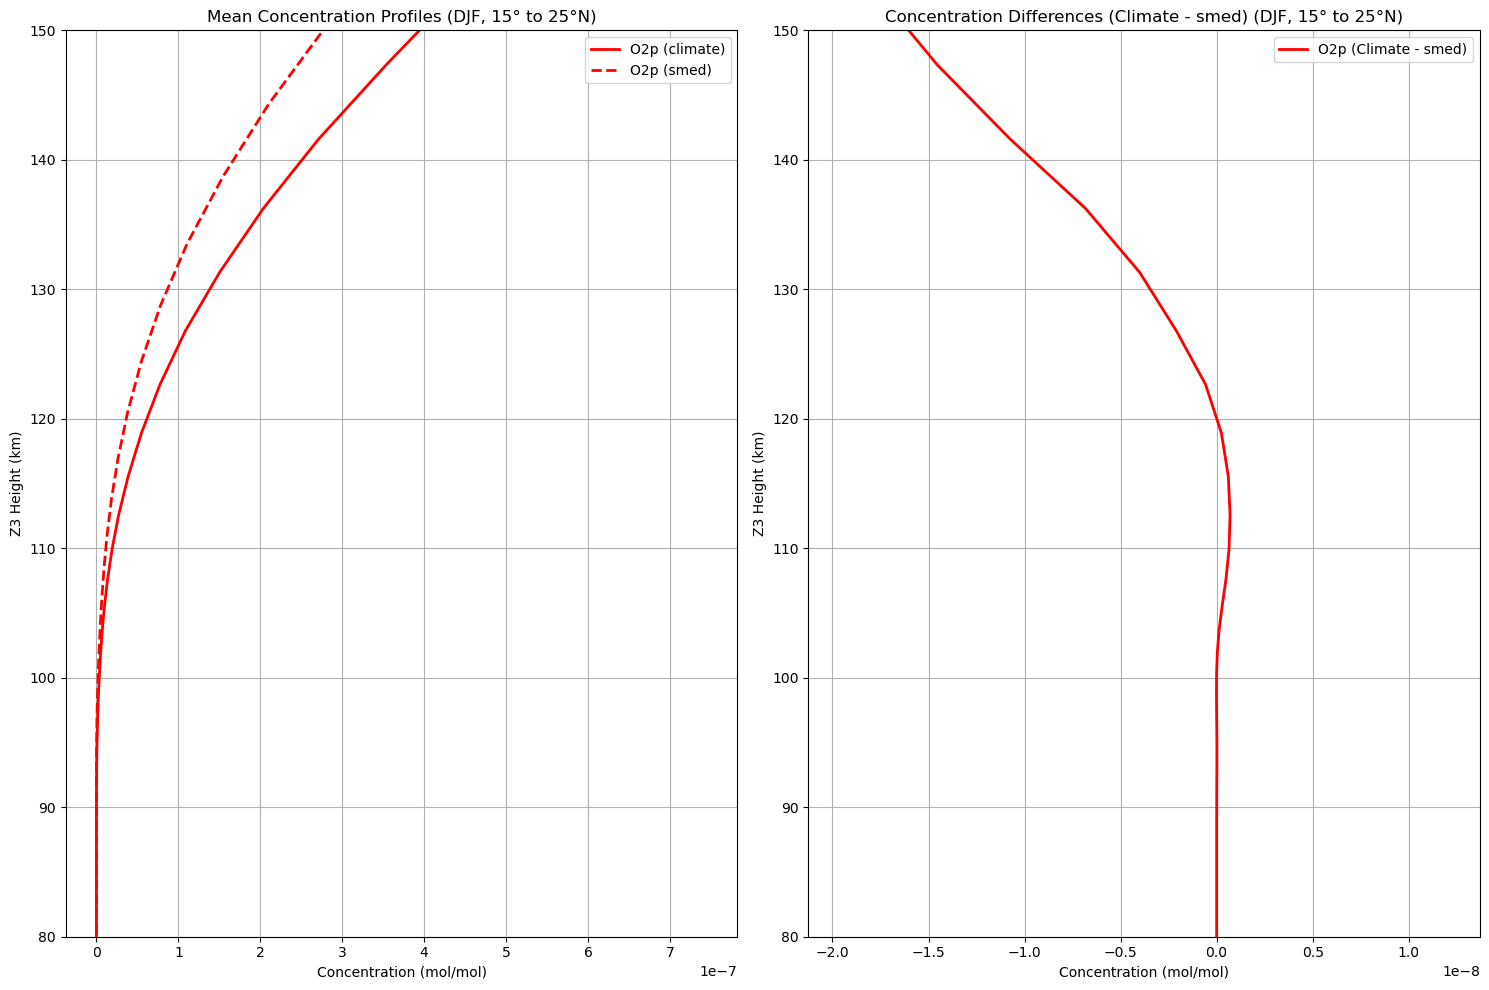

In [30]:
climate_path = "/resstore/b0243/Data/Sporadic_E/FX2100f19f19mg16NaFeMgiontransport_OUTPUT/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
Smed_path = "/resstore/b0243/Data/Sporadic_E/Solar_Med/archive_yr2000/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-{month}-{day}-*.nc"
plot_height_profile_ions(climate_path, Smed_path)

In [12]:
def plot_height_profile_ions(base_path_climate, base_path_smed):
    fig = plt.figure(figsize=(15, 10))
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    data = {
        'climate': {'O2p': [], 'Op': [], 'O3': [], 'heights': []},
        'smed': {'O2p': [], 'Op': [], 'O3': [], 'heights': []}
    }

    target_months = [f"{i:02d}" for i in range(3, 6)]
    
    for scenario, base_path in [('climate', base_path_climate), ('smed', base_path_smed)]:
        for month in target_months:
            file_pattern = base_path.format(month=month, day='*')
            files = glob.glob(file_pattern)
            
            ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')

            lat_mask = (ds.lat >= -55) & (ds.lat <= -45)
            ds_filtered = ds.sel(lat=ds.lat[lat_mask])
            
            for element in ['O2p']:
                element_profile = ds_filtered[element].mean(dim=['time', 'lat', 'lon'])
                data[scenario][element].append(element_profile.values)

            z3_var = ds_filtered.variables['Z3']
            h_geopotential = z3_var.mean(dim=['time', 'lat', 'lon'])
            data[scenario]['heights'].append(h_geopotential.values / 1000.0)
            
            ds.close()
            
    for scenario in data:
        for element in ['O2p', 'Op', 'O3']:
            data[scenario][element] = np.array(data[scenario][element])
        data[scenario]['heights'] = np.array(data[scenario]['heights'])
        data[scenario]['mean_height'] = np.mean(data[scenario]['heights'], axis=0)
    
    colors = {'O2p': 'r', 'Op': 'g', 'O3': 'b'}
    line_styles = {'climate': '-', 'smed': '--'}
    
    for element, color in colors.items():
        for scenario, linestyle in line_styles.items():
            seasonal_mean = np.mean(data[scenario][element], axis=0)
            ax1.plot(
                seasonal_mean, 
                data[scenario]['mean_height'], 
                color=color, 
                linestyle=linestyle, 
                linewidth=2, 
                label=f'{element} ({scenario})'
            )
    
    for element, color in colors.items():
        climate_mean = np.mean(data['climate'][element], axis=0)
        smed_mean = np.mean(data['smed'][element], axis=0)
        difference = climate_mean - smed_mean
        ax2.plot(
            difference, 
            data['climate']['mean_height'], 
            color=color, 
            linewidth=2, 
            label=f'{element} (Climate - smed)'
        )
    
    for ax, title in [(ax1, 'Mean Concentration Profiles (MAM, -55°N to -45°N)'), 
                       (ax2, 'Concentration Differences (Climate - smed) (MAM, -55°N to -45°N)')]:
        ax.grid(True)
        ax.set_xlabel('Concentration (mol/mol)')
        ax.set_ylabel('Z3 Height (km)')  # Updated label to reflect Z3 usage
        ax.set_title(title)
        ax.set_ylim(80, 150)
        # ax.set_xlim()
        ax.legend()
    
    plt.tight_layout()
    return fig

/home/home02/py21cb/.conda/envs/Es/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/home02/py21cb/.conda/envs/Es/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: x and y must have same first dimension, but have shapes (1,) and (126,)

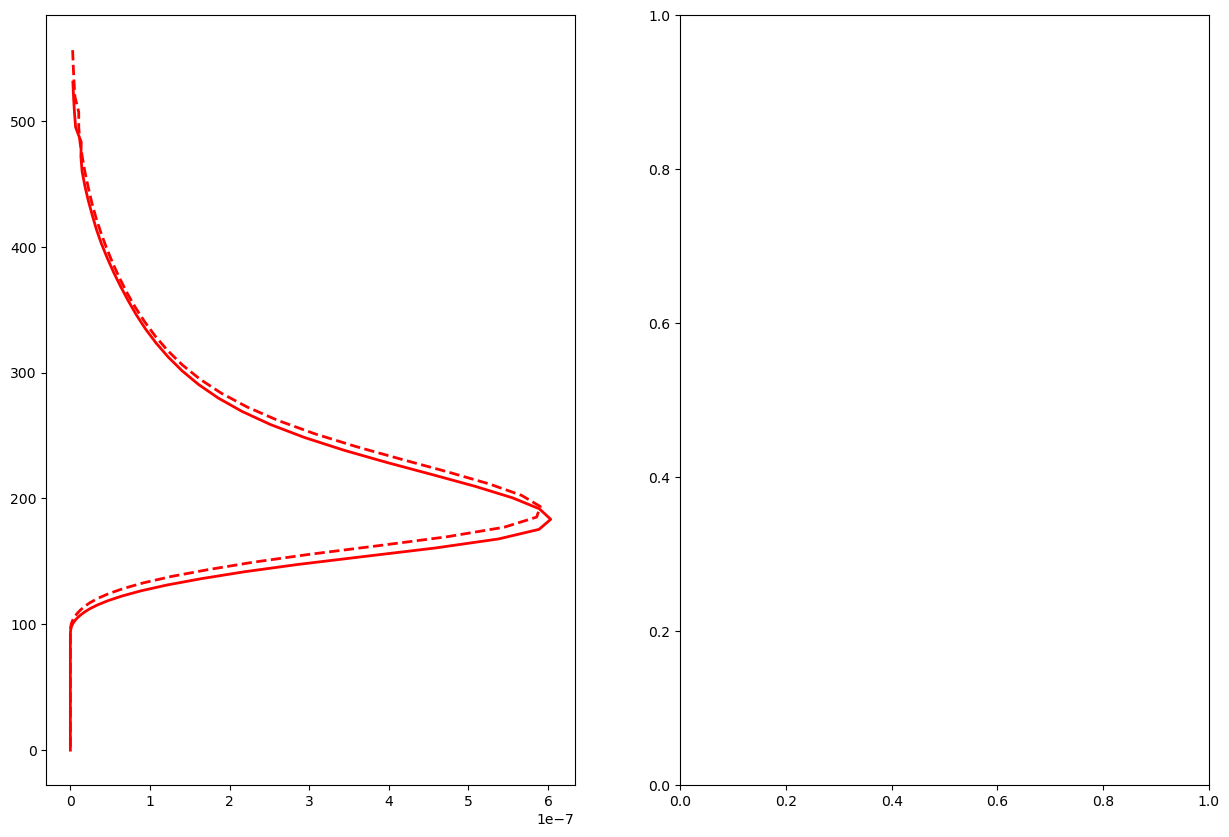

In [13]:
climate_path = "/resstore/b0243/Data/Sporadic_E/FX2100f19f19mg16NaFeMgiontransport_OUTPUT/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
Smed_path = "/resstore/b0243/Data/Sporadic_E/Solar_Med/archive_yr2000/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-{month}-{day}-*.nc"
plot_height_profile_ions(climate_path, Smed_path)

In [4]:
def plot_height_profile_ions(base_path_climate, base_path_smed, output_dir='./output_data'):
    fig = plt.figure(figsize=(15, 10))
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    data = {
        'climate': {'Fep': [], 'Mgp': [], 'Nap': [], 'heights': []},
        'smed': {'Fep': [], 'Mgp': [], 'Nap': [], 'heights': []}
    }
    
    target_months = ['09', '10', '11']
    
    for scenario, base_path in [('climate', base_path_climate), ('smed', base_path_smed)]:
        for month in target_months:
            file_pattern = base_path.format(month=month, day='*')
            files = glob.glob(file_pattern)
            
            ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')

            lat_mask = (ds.lat >= -70) & (ds.lat <= -60)
            ds_filtered = ds.sel(lat=ds.lat[lat_mask])
            
            for element in ['Fep', 'Mgp', 'Nap']:
                element_profile = ds_filtered[element].mean(dim=['time', 'lat', 'lon'])
                data[scenario][element].append(element_profile.values)

            z3_var = ds_filtered.variables['Z3']
            h_geopotential = z3_var[0, :, :, :].mean(dim=['lat', 'lon']) 

            data[scenario]['heights'].append(h_geopotential.values / 1000.0)
            
            ds.close()
            
    for scenario in data:
        for element in ['Fep', 'Mgp', 'Nap']:
            data[scenario][element] = np.array(data[scenario][element])
        data[scenario]['heights'] = np.array(data[scenario]['heights'])
        data[scenario]['mean_height'] = np.mean(data[scenario]['heights'], axis=0)

    os.makedirs(output_dir, exist_ok=True)

    for element in ['Fep', 'Mgp', 'Nap']:
        for scenario in ['climate', 'smed']:
            seasonal_mean = np.mean(data[scenario][element], axis=0)
            heights = data[scenario]['mean_height']
            
            filename = f"{output_dir}/{element}_{scenario}_mean_concentration.txt"
            with open(filename, 'w') as f:
                f.write(f"# {element} mean concentration profile for {scenario} scenario (SON, -70° to -60°N)\n")
                f.write("# Height(km)\tConcentration(mol/mol)\n")
                for i in range(len(heights)):
                    f.write(f"{heights[i]:.6f}\t{seasonal_mean[i]:.6e}\n")

        climate_mean = np.mean(data['climate'][element], axis=0)
        smed_mean = np.mean(data['smed'][element], axis=0)
        difference = climate_mean - smed_mean
        heights = data['climate']['mean_height']
        
        filename = f"{output_dir}/{element}_difference_concentration.txt"
        with open(filename, 'w') as f:
            f.write(f"# {element} concentration difference (Climate - smed) (SON, -70° to -60°N)\n")
            f.write("# Height(km)\tDifference(mol/mol)\n")
            for i in range(len(heights)):
                f.write(f"{heights[i]:.6f}\t{difference[i]:.6e}\n")
    
    colors = {'Fep': 'r', 'Mgp': 'g', 'Nap': 'b'}
    line_styles = {'climate': '-', 'smed': '--'}
    
    for element, color in colors.items():
        for scenario, linestyle in line_styles.items():
            seasonal_mean = np.mean(data[scenario][element], axis=0)
            ax1.plot(
                seasonal_mean, 
                data[scenario]['mean_height'], 
                color=color, 
                linestyle=linestyle, 
                linewidth=2, 
                label=f'{element} ({scenario})'
            )
    
    for element, color in colors.items():
        climate_mean = np.mean(data['climate'][element], axis=0)
        smed_mean = np.mean(data['smed'][element], axis=0)
        difference = climate_mean - smed_mean
        ax2.plot(
            difference, 
            data['climate']['mean_height'], 
            color=color, 
            linewidth=2, 
            label=f'{element} (Climate - smed)'
        )
        
    for ax, title in [(ax1, 'Mean Concentration Profiles (SON, -70° to -60°N)'), 
                       (ax2, 'Concentration Differences (Climate - smed) (SON, -70° to -60°N)')]:
        ax.grid(True)
        ax.set_xlabel('Concentration (mol/mol)')
        ax.set_ylabel('Z3 Height (km)')
        ax.set_title(title)
        ax.set_ylim(80,150)
        ax.legend()

    plt.tight_layout()
    return fig

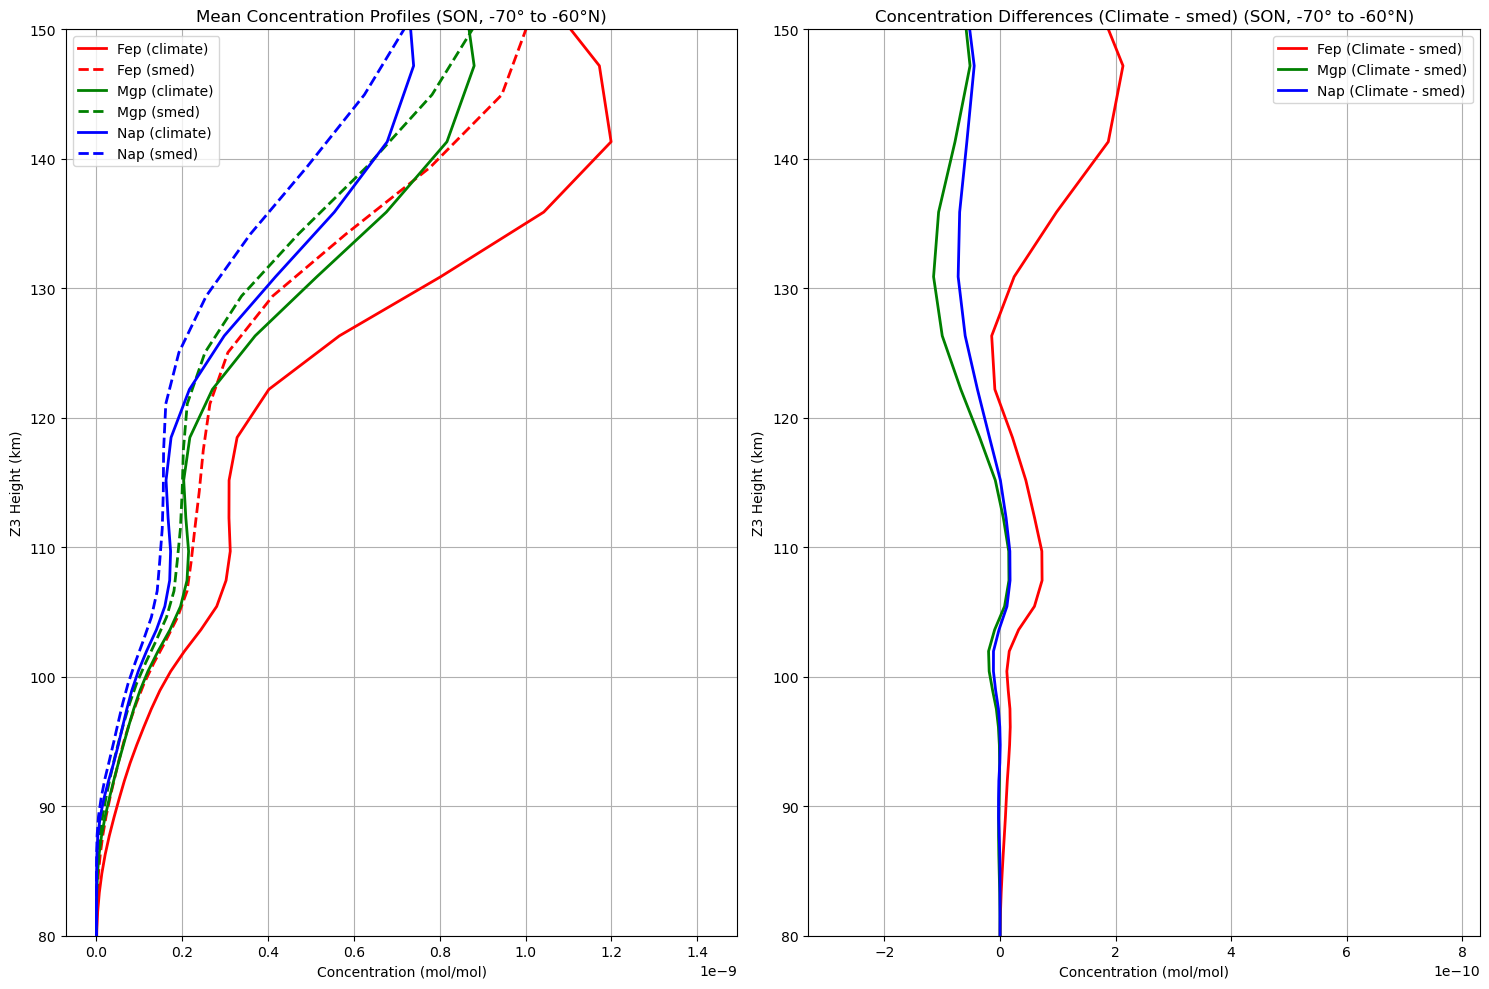

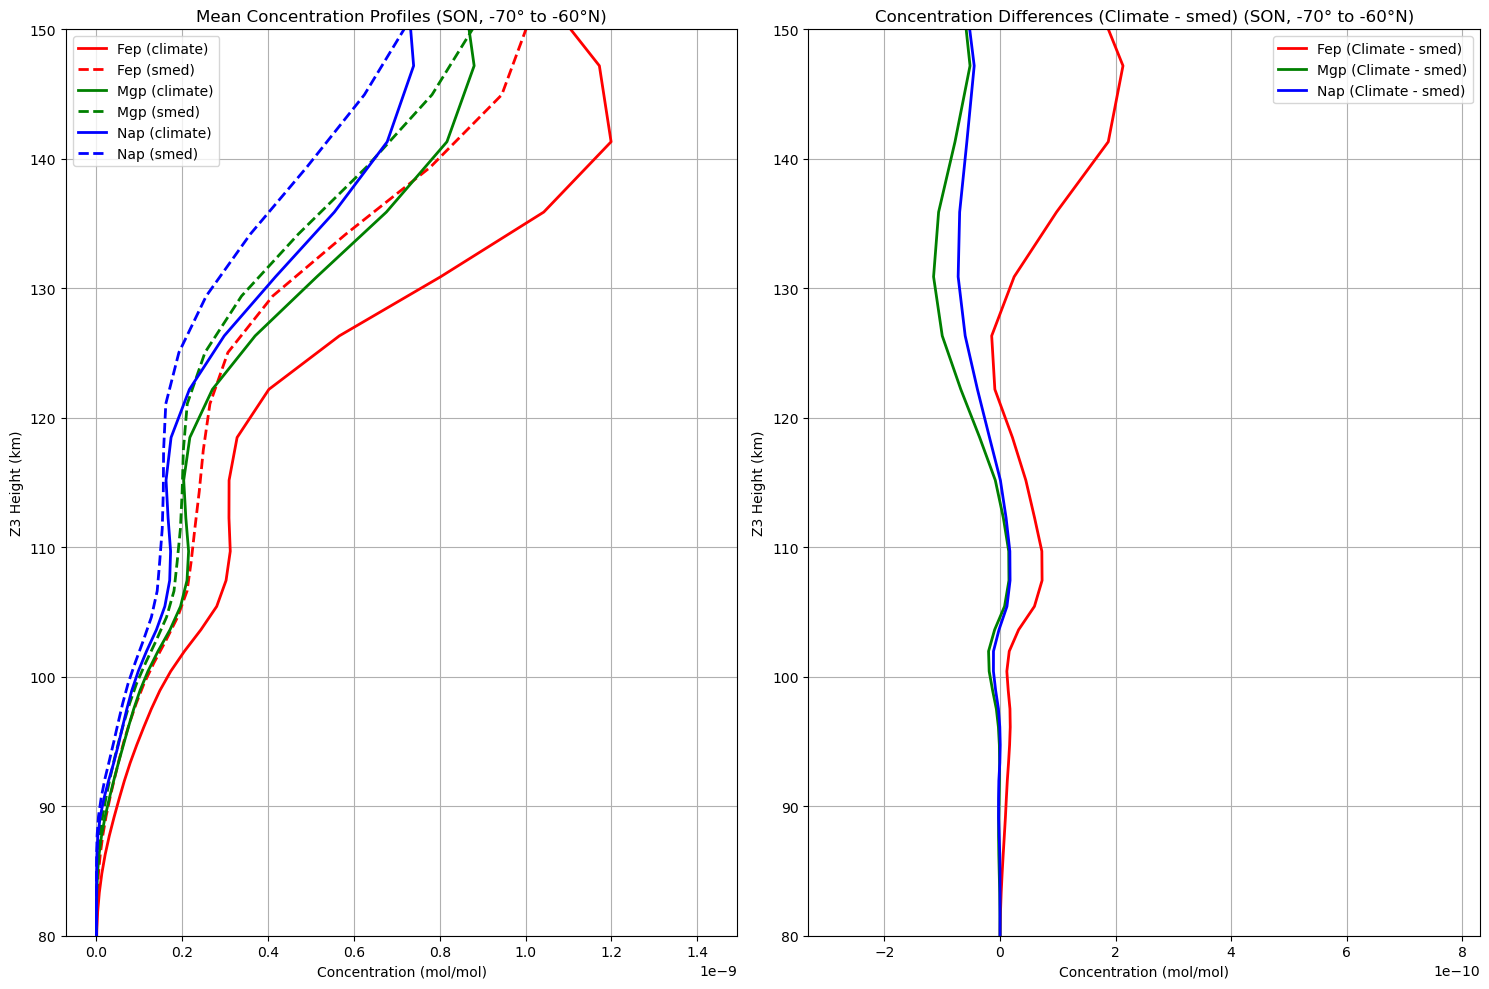

In [5]:
climate_path = "/resstore/b0243/Data/Sporadic_E/FX2100f19f19mg16NaFeMgiontransport_OUTPUT/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
Smed_path = "/resstore/b0243/Data/Sporadic_E/Solar_Med/archive_yr2000/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-{month}-{day}-*.nc"
plot_height_profile_ions(climate_path, Smed_path)

In [8]:
def plot_height_profile_ions(base_path_climate, base_path_climate_janfeb, base_path_smed, output_dir='./output_data'):
    fig = plt.figure(figsize=(15, 10))

    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    data = {
        'climate': {'Fep': [], 'Mgp': [], 'Nap': [], 'heights': []},
        'smed': {'Fep': [], 'Mgp': [], 'Nap': [], 'heights': []}
    }

    target_months = ['12', '01', '02']

    for scenario, base_paths in [
        ('climate', 
         {
             '12': base_path_climate,
             '01': base_path_climate_janfeb,
             '02': base_path_climate_janfeb
         }
        ), 
        ('smed', {month: base_path_smed for month in target_months})
    ]:
        for month in target_months:
            file_pattern = base_paths[month].format(month=month, day='*')
            files = glob.glob(file_pattern)

            ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')

            lat_mask = (ds.lat >= 15) & (ds.lat <= 25)
            ds_filtered = ds.sel(lat=ds.lat[lat_mask])

            for element in ['Fep', 'Mgp', 'Nap']:
                element_profile = ds_filtered[element].mean(dim=['time', 'lat', 'lon'])
                data[scenario][element].append(element_profile.values)

            z3_var = ds_filtered.variables['Z3']
            h_geopotential = z3_var[0, :, :, :].mean(dim=['lat', 'lon'])

            data[scenario]['heights'].append(h_geopotential.values / 1000.0)

            ds.close()

    for scenario in data:
        for element in ['Fep', 'Mgp', 'Nap']:
            data[scenario][element] = np.array(data[scenario][element])
        data[scenario]['heights'] = np.array(data[scenario]['heights'])
        data[scenario]['mean_height'] = np.mean(data[scenario]['heights'], axis=0)

    os.makedirs(output_dir, exist_ok=True)

    for element in ['Fep', 'Mgp', 'Nap']:
        for scenario in ['climate', 'smed']:
            seasonal_mean = np.mean(data[scenario][element], axis=0)
            heights = data[scenario]['mean_height']

            filename = f"{output_dir}/{element}_{scenario}_mean_concentration.txt"
            with open(filename, 'w') as f:
                f.write(f"# {element} mean concentration profile for {scenario} scenario (DJF, 15° to 25°N)\n")
                f.write("# Height(km)\tConcentration(mol/mol)\n")
                for i in range(len(heights)):
                    f.write(f"{heights[i]:.6f}\t{seasonal_mean[i]:.6e}\n")

        climate_mean = np.mean(data['climate'][element], axis=0)
        smed_mean = np.mean(data['smed'][element], axis=0)
        difference = climate_mean - smed_mean
        heights = data['climate']['mean_height']

        filename = f"{output_dir}/{element}_difference_concentration.txt"
        with open(filename, 'w') as f:
            f.write(f"# {element} concentration difference (Climate - smed) (DJF, 15° to 25°N)\n")
            f.write("# Height(km)\tDifference(mol/mol)\n")
            for i in range(len(heights)):
                f.write(f"{heights[i]:.6f}\t{difference[i]:.6e}\n")

    colors = {'Fep': 'r', 'Mgp': 'g', 'Nap': 'b'}
    line_styles = {'climate': '-', 'smed': '--'}

    for element, color in colors.items():
        for scenario, linestyle in line_styles.items():
            seasonal_mean = np.mean(data[scenario][element], axis=0) / 1e-10
            ax1.plot(
                seasonal_mean, 
                data[scenario]['mean_height'], 
                color=color, 
                linestyle=linestyle, 
                linewidth=2, 
                label=f'{element} ({scenario})'
            )

    for element, color in colors.items():
        climate_mean = np.mean(data['climate'][element], axis=0) / 1e-10
        smed_mean = np.mean(data['smed'][element], axis=0) / 1e-10
        difference = climate_mean - smed_mean
        ax2.plot(
            difference, 
            data['climate']['mean_height'], 
            color=color, 
            linewidth=2, 
            label=f'{element} (Climate - smed)'
        )

    for ax, title in [(ax1, 'Mean Concentration Profiles (DJF, 15° to 25°N)'), 
                      (ax2, 'Concentration Differences (Climate - smed) (DJF, 15° to 25°N)')]:
        ax.grid(True)
        ax.set_xlabel('Mixing ratio (mol/mol)')
        ax.set_ylabel('Z3 Height (km)')
        ax.set_title(title)
        ax.set_ylim(80, 150)
        ax.set_xlim(-2, 3)
        ax.legend()

    plt.tight_layout()
    return fig

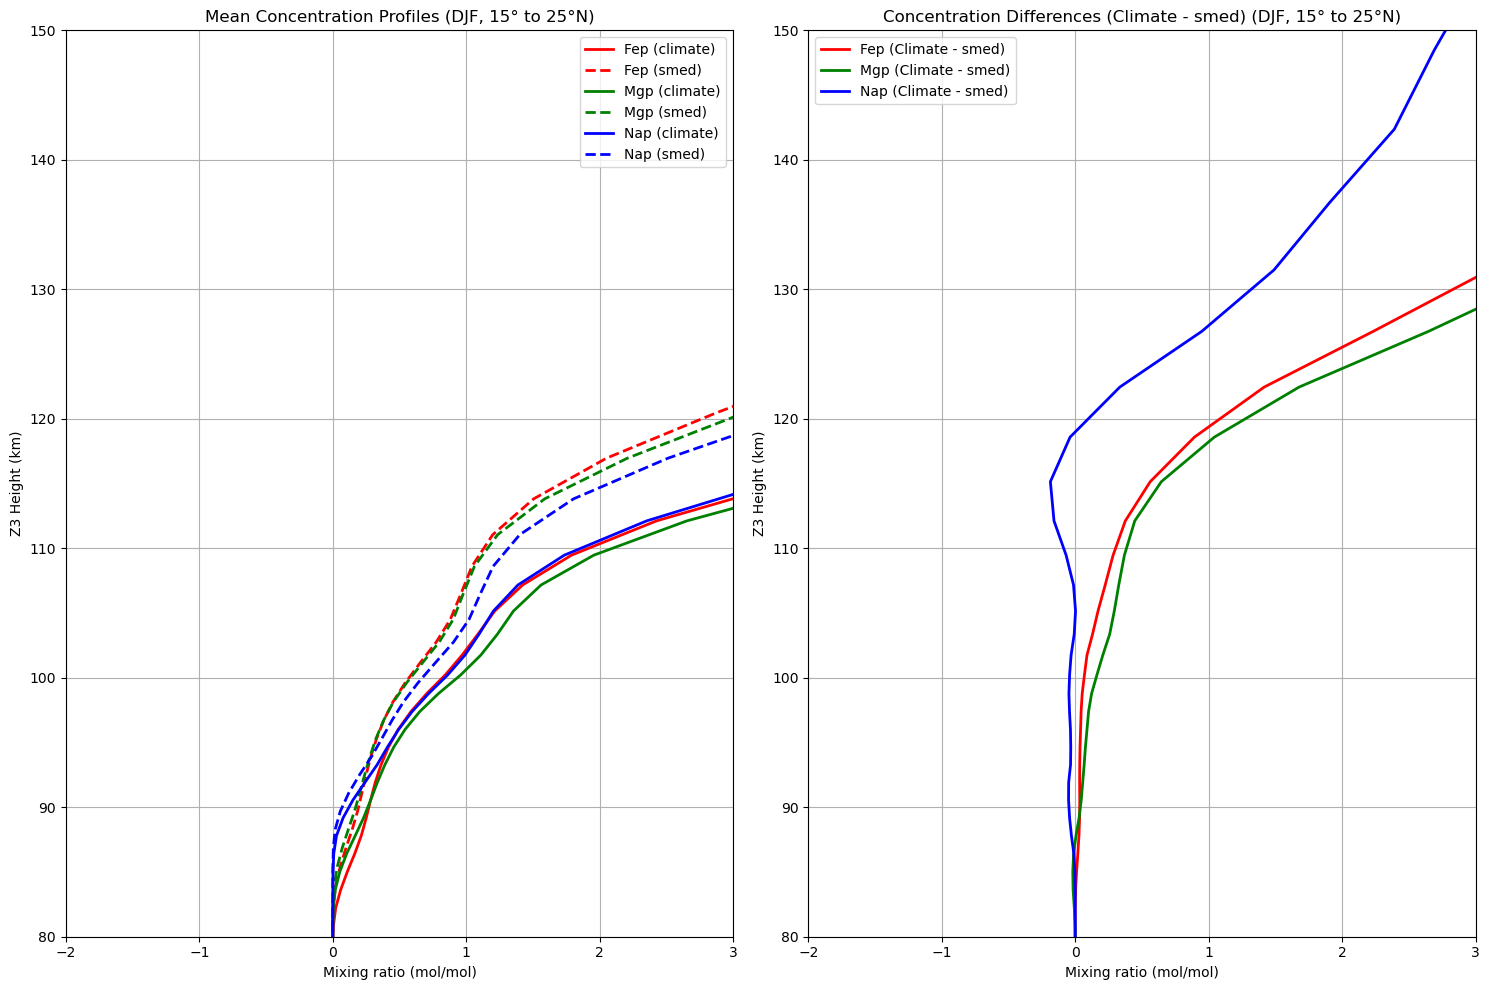

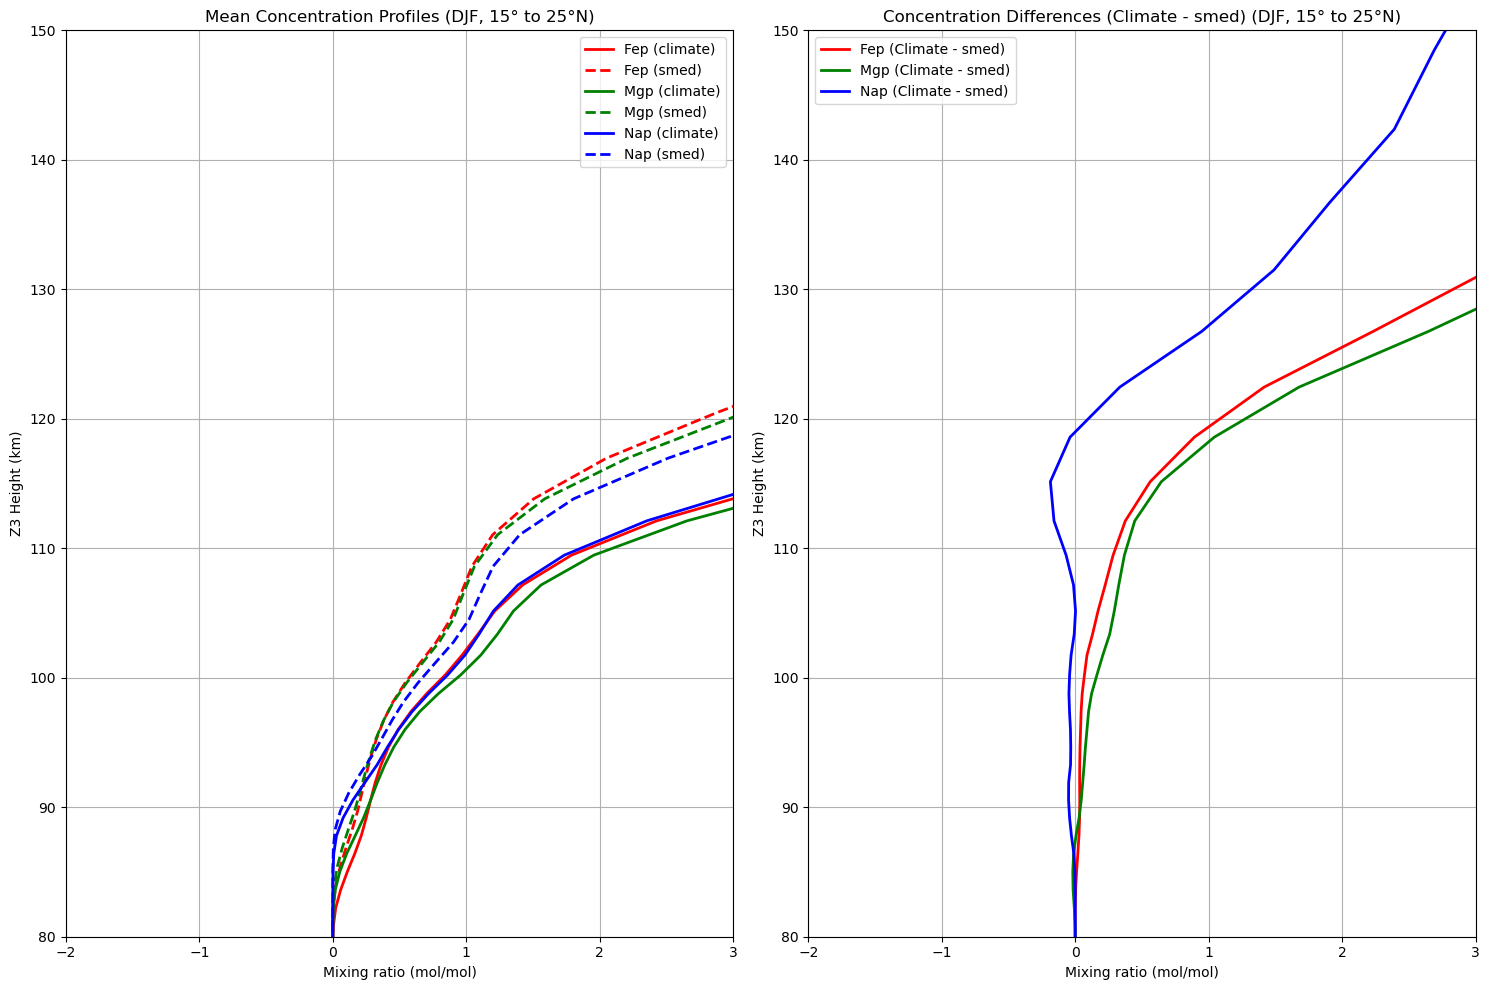

In [9]:
climate_path = "/resstore/b0243/Data/Sporadic_E/FX2100f19f19mg16NaFeMgiontransport_OUTPUT/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
climate_janfeb = "/resstore/b0243/Data/Sporadic_E/FX2101f19f19mg16NaFeMgiontransport_OUTPUT/atm/hist/FX2101f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
Smed_path = "/resstore/b0243/Data/Sporadic_E/Solar_Med/archive_yr2000/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-{month}-{day}-*.nc"
plot_height_profile_ions(climate_path, climate_janfeb, Smed_path)